In [3]:
import tensorflow as tf
import yfinance as yf
from yahoo_fin.stock_info import get_data
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [18]:
# Imports 3 years of BTC daily data from yahoo finance
BTC_df = get_data("BTC-USD", start_date="6/30/2019", end_date="06/30/2022", index_as_date = True, interval="1d")
df = BTC_df.iloc[:,0:-1]
df.head()

,open,high,low,close,adjclose,volume
2019-06-30,11931.991211,12178.383789,10799.008789,10817.155273,10817.155273,27256473494
2019-07-01,10796.930664,11206.439453,10089.314453,10583.134766,10583.134766,29378589324
2019-07-02,10588.683594,10912.188477,9737.884766,10801.677734,10801.677734,31015895223
2019-07-03,10818.156250,11968.078125,10818.156250,11961.269531,11961.269531,30796494294
2019-07-04,11972.718750,12006.075195,11166.569336,11215.437500,11215.437500,25920294033


In [19]:
# Defines function to split X and y data
def window_data(df, window, feature_col_number, target_col_number):
    # Creates empty X and y list
    X = []
    y = []
    # loops through btc data
    for i in range(len(df) - window - 1):
        # splits the features by grouping window amount of previous close data
        features = df.iloc[i:(i + window), feature_col_number]
        # splits target by taking current close values
        target = df.iloc[(i + window), target_col_number]
        # Adds end of each loops data to respective X and y list
        X.append(features)
        y.append(target)
    # returns X,y as arrays
    return np.array(X), np.array(y).reshape(-1, 1)

In [20]:
# Defines window size
window_size=10

In [21]:
# Runs function to split X and y data
X, y=window_data(df, window_size, 3, 3)
# Displays X and y
display(X)
display(y)

array([[10817.15527344, 10583.13476562, 10801.67773438, ...,
        11450.84667969, 12285.95800781, 12573.8125    ],
       [10583.13476562, 10801.67773438, 11961.26953125, ...,
        12285.95800781, 12573.8125    , 12156.51269531],
       [10801.67773438, 11961.26953125, 11215.4375    , ...,
        12573.8125    , 12156.51269531, 11358.66210938],
       ...,
       [20471.48242188, 19017.64257812, 20553.27148438, ...,
        21231.65625   , 21502.33789062, 21027.29492188],
       [19017.64257812, 20553.27148438, 20599.53710938, ...,
        21502.33789062, 21027.29492188, 20735.47851562],
       [20553.27148438, 20599.53710938, 20710.59765625, ...,
        21027.29492188, 20735.47851562, 20280.63476562]])

array([[12156.51269531],
       [11358.66210938],
       [11815.98632812],
       ...,
       [20735.47851562],
       [20280.63476562],
       [20104.0234375 ]])

In [22]:
# Scales X and y data using MinMaxScaler
X_scaler=MinMaxScaler()
X_scaler.fit(X)
X_scaled=X_scaler.transform(X)
y_scaler=MinMaxScaler()
y_scaler.fit(y)
y_scaled=y_scaler.transform(y)

In [23]:
# Defines where train and test data will be split (70% is train)
split=int(0.7*len(X_scaled))
# Splits train and test data
X_train=X_scaled[:split]
X_test=X_scaled[split:]
y_train=y_scaled[:split]
y_test=y_scaled[split:]

In [8]:
#X_scaled=X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)
#display(X.shape)

(1086, 10)

In [24]:
# Reshapes data into size LSTM can handle
X_train=X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test=X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
display(X_train.shape)
display(X_test.shape)

(760, 10, 1)

(326, 10, 1)

In [25]:
# Creates neural network
model=Sequential()
# Defines and adds LSTM layer
first_lstm_layer=LSTM(units=30, return_sequences=True, input_shape=(window_size, 1))
model.add(first_lstm_layer)
# Randomly drops 20% of defined nodes
first_dropout_layer=Dropout(0.2)
# Defines and adds LSTM layer
model.add(first_dropout_layer)
second_lstm_layer=LSTM(units=30, return_sequences=True)
model.add(second_lstm_layer)
# Randomly drops 20% of defined nodes
second_dropout_layer=Dropout(0.2)
# Defines and adds LSTM layer
model.add(second_dropout_layer)
third_lstm_layer=LSTM(units=30)
model.add(third_lstm_layer)
# Defines and adds output layer with linear activation
output_layer=Dense(units=1, activation='linear')
model.add(output_layer)

In [26]:
# Compiles model
model.compile(loss='mean_squared_error', optimizer='adam', metrics='mean_squared_error')

In [27]:
# Provides summary of model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10, 30)            3840      
                                                                 
 dropout_2 (Dropout)         (None, 10, 30)            0         
                                                                 
 lstm_4 (LSTM)               (None, 10, 30)            7320      
                                                                 
 dropout_3 (Dropout)         (None, 10, 30)            0         
                                                                 
 lstm_5 (LSTM)               (None, 30)                7320      
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 18,511
Trainable params: 18,511
Non-trai

In [28]:
# Initially fits model using training data
model.fit(X_train, y_train, epochs=50)

Epoch 1/50
24/24 [==============================] - 7s 19ms/step - loss: 0.0437 - mean_squared_error: 0.0437
Epoch 2/50
24/24 [==============================] - 0s 18ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 3/50
24/24 [==============================] - 0s 17ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 4/50
24/24 [==============================] - 0s 17ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 5/50
24/24 [==============================] - 0s 18ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 6/50
24/24 [==============================] - 0s 17ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 7/50
24/24 [==============================] - 0s 18ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 8/50
24/24 [==============================] - 1s 21ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 9/50
24/24 [==============================] - 0s 20ms/step - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 10/50
24/24 [

In [32]:
# Projects future data by using model to predict next close and then uses that value to retrain 
# the model before making next prediction
for i in range(326): 
    # predicts next close value and reshapes it
    prediction_scaled=model.predict(X_train[-1].reshape(1, window_size, 1))
    # transforms prediction back to original scale
    next_prediction=y_scaler.inverse_transform(prediction_scaled)
    # displays predicted close value
    display(next_prediction)
    # adds predicted close value to list
    new_train_sample=np.append(X_train[-1], prediction_scaled)[1:].reshape(1, window_size, 1)
    # adds new list entry of predicted close to X train
    X_train=np.append(X_train, new_train_sample, axis=0)
    # adds new list entry of predicted close to y train
    y_train=np.append(y_train, prediction_scaled, axis=0)
    # refits model with new close value
    model.fit(X_train, y_train, epochs=5)

1/1 [==============================] - 2s 2s/step


array([[42046.6]], dtype=float32)

Epoch 1/5
24/24 [==============================] - 0s 18ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 2/5
24/24 [==============================] - 1s 21ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 3/5
24/24 [==============================] - 0s 18ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 4/5
24/24 [==============================] - 0s 17ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[39353.312]], dtype=float32)

Epoch 1/5
24/24 [==============================] - 0s 19ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 2/5
24/24 [==============================] - 0s 19ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 3/5
24/24 [==============================] - 0s 18ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 4/5
24/24 [==============================] - 0s 18ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[40967.297]], dtype=float32)

Epoch 1/5
24/24 [==============================] - 0s 18ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 2/5
24/24 [==============================] - 0s 18ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 3/5
24/24 [==============================] - 0s 17ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 4/5
24/24 [==============================] - 0s 17ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[42643.195]], dtype=float32)

Epoch 1/5
24/24 [==============================] - 0s 19ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 2/5
24/24 [==============================] - 0s 17ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 3/5
24/24 [==============================] - 0s 17ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 4/5
24/24 [==============================] - 0s 16ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[40098.016]], dtype=float32)

Epoch 1/5
24/24 [==============================] - 1s 23ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 2/5
24/24 [==============================] - 0s 18ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 3/5
24/24 [==============================] - 0s 19ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 4/5
24/24 [==============================] - 0s 19ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[43238.73]], dtype=float32)

Epoch 1/5
24/24 [==============================] - 0s 17ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 2/5
24/24 [==============================] - 0s 19ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 3/5
24/24 [==============================] - 0s 19ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 4/5
24/24 [==============================] - 0s 19ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[41160.918]], dtype=float32)

Epoch 1/5
24/24 [==============================] - 1s 25ms/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 2/5
24/24 [==============================] - 0s 19ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 3/5
24/24 [==============================] - 0s 18ms/step - loss: 9.7346e-04 - mean_squared_error: 9.7346e-04
Epoch 4/5
24/24 [==============================] - 0s 17ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[41255.1]], dtype=float32)

Epoch 1/5
24/24 [==============================] - 0s 17ms/step - loss: 9.8249e-04 - mean_squared_error: 9.8249e-04
Epoch 2/5
24/24 [==============================] - 0s 17ms/step - loss: 9.3117e-04 - mean_squared_error: 9.3117e-04
Epoch 3/5
24/24 [==============================] - 0s 18ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 4/5
24/24 [==============================] - 1s 24ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[42965.34]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 18ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 2/5
25/25 [==============================] - 0s 19ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 3/5
25/25 [==============================] - 1s 21ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 4/5
25/25 [==============================] - 1s 22ms/step - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 5/5
1/1 [==============================] - 0s 29ms/step


array([[41088.34]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 1s 24ms/step - loss: 0.0010 - mean_squared_error: 0.0010   
Epoch 2/5
25/25 [==============================] - 1s 23ms/step - loss: 9.2820e-04 - mean_squared_error: 9.2820e-04
Epoch 3/5
25/25 [==============================] - 1s 23ms/step - loss: 9.6571e-04 - mean_squared_error: 9.6571e-04
Epoch 4/5
25/25 [==============================] - 1s 21ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 5/5
1/1 [==============================] - 0s 31ms/step


array([[42696.594]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 1s 21ms/step - loss: 8.9400e-04 - mean_squared_error: 8.9400e-04
Epoch 2/5
25/25 [==============================] - 1s 22ms/step - loss: 8.9928e-04 - mean_squared_error: 8.9928e-04
Epoch 3/5
25/25 [==============================] - 1s 23ms/step - loss: 8.7716e-04 - mean_squared_error: 8.7716e-04
Epoch 4/5
25/25 [==============================] - 1s 21ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 5/5
1/1 [==============================] - 0s 39ms/step


array([[42906.152]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 1s 22ms/step - loss: 9.2172e-04 - mean_squared_error: 9.2172e-04
Epoch 2/5
25/25 [==============================] - 1s 21ms/step - loss: 8.1856e-04 - mean_squared_error: 8.1856e-04
Epoch 3/5
25/25 [==============================] - 1s 24ms/step - loss: 9.8440e-04 - mean_squared_error: 9.8440e-04
Epoch 4/5
25/25 [==============================] - 1s 22ms/step - loss: 8.6703e-04 - mean_squared_error: 8.6703e-04
Epoch 5/5
1/1 [==============================] - 0s 32ms/step


array([[43148.09]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 1s 23ms/step - loss: 8.9668e-04 - mean_squared_error: 8.9668e-04
Epoch 2/5
25/25 [==============================] - 1s 25ms/step - loss: 8.1679e-04 - mean_squared_error: 8.1679e-04
Epoch 3/5
25/25 [==============================] - 1s 27ms/step - loss: 8.4769e-04 - mean_squared_error: 8.4769e-04
Epoch 4/5
25/25 [==============================] - 1s 22ms/step - loss: 8.7839e-04 - mean_squared_error: 8.7839e-04
Epoch 5/5
1/1 [==============================] - 0s 32ms/step


array([[43313.19]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 1s 21ms/step - loss: 7.4811e-04 - mean_squared_error: 7.4811e-04
Epoch 2/5
25/25 [==============================] - 1s 21ms/step - loss: 7.5634e-04 - mean_squared_error: 7.5634e-04
Epoch 3/5
25/25 [==============================] - 1s 21ms/step - loss: 8.2454e-04 - mean_squared_error: 8.2454e-04
Epoch 4/5
25/25 [==============================] - 1s 21ms/step - loss: 7.3377e-04 - mean_squared_error: 7.3377e-04
Epoch 5/5
1/1 [==============================] - 0s 31ms/step


array([[44882.438]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 1s 22ms/step - loss: 7.8187e-04 - mean_squared_error: 7.8187e-04
Epoch 2/5
25/25 [==============================] - 1s 22ms/step - loss: 8.2992e-04 - mean_squared_error: 8.2992e-04
Epoch 3/5
25/25 [==============================] - 1s 24ms/step - loss: 7.1911e-04 - mean_squared_error: 7.1911e-04
Epoch 4/5
25/25 [==============================] - 1s 22ms/step - loss: 6.9897e-04 - mean_squared_error: 6.9897e-04
Epoch 5/5
1/1 [==============================] - 0s 31ms/step


array([[43273.63]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 1s 21ms/step - loss: 8.5745e-04 - mean_squared_error: 8.5745e-04
Epoch 2/5
25/25 [==============================] - 1s 24ms/step - loss: 7.9273e-04 - mean_squared_error: 7.9273e-04
Epoch 3/5
25/25 [==============================] - 1s 23ms/step - loss: 7.9448e-04 - mean_squared_error: 7.9448e-04
Epoch 4/5
25/25 [==============================] - 1s 21ms/step - loss: 8.1748e-04 - mean_squared_error: 8.1748e-04
Epoch 5/5
1/1 [==============================] - 0s 33ms/step


array([[44083.2]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 1s 23ms/step - loss: 7.2104e-04 - mean_squared_error: 7.2104e-04
Epoch 2/5
25/25 [==============================] - 1s 22ms/step - loss: 7.9504e-04 - mean_squared_error: 7.9504e-04
Epoch 3/5
25/25 [==============================] - 1s 22ms/step - loss: 7.4215e-04 - mean_squared_error: 7.4215e-04
Epoch 4/5
25/25 [==============================] - 1s 21ms/step - loss: 7.8710e-04 - mean_squared_error: 7.8710e-04
Epoch 5/5
1/1 [==============================] - 0s 45ms/step


array([[44162.203]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 1s 27ms/step - loss: 7.8066e-04 - mean_squared_error: 7.8066e-04
Epoch 2/5
25/25 [==============================] - 1s 28ms/step - loss: 6.9923e-04 - mean_squared_error: 6.9923e-04
Epoch 3/5
25/25 [==============================] - 1s 22ms/step - loss: 8.9976e-04 - mean_squared_error: 8.9976e-04
Epoch 4/5
25/25 [==============================] - 1s 21ms/step - loss: 7.4285e-04 - mean_squared_error: 7.4285e-04
Epoch 5/5
1/1 [==============================] - 0s 31ms/step


array([[44357.668]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 17ms/step - loss: 8.0217e-04 - mean_squared_error: 8.0217e-04
Epoch 2/5
25/25 [==============================] - 0s 17ms/step - loss: 7.5416e-04 - mean_squared_error: 7.5416e-04
Epoch 3/5
25/25 [==============================] - 0s 18ms/step - loss: 7.4828e-04 - mean_squared_error: 7.4828e-04
Epoch 4/5
25/25 [==============================] - 0s 17ms/step - loss: 7.2599e-04 - mean_squared_error: 7.2599e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[43714.32]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 17ms/step - loss: 7.6036e-04 - mean_squared_error: 7.6036e-04
Epoch 2/5
25/25 [==============================] - 0s 18ms/step - loss: 7.8592e-04 - mean_squared_error: 7.8592e-04
Epoch 3/5
25/25 [==============================] - 0s 19ms/step - loss: 6.7715e-04 - mean_squared_error: 6.7715e-04
Epoch 4/5
25/25 [==============================] - 0s 17ms/step - loss: 7.2845e-04 - mean_squared_error: 7.2845e-04
Epoch 5/5
1/1 [==============================] - 0s 33ms/step


array([[43333.805]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 17ms/step - loss: 7.8125e-04 - mean_squared_error: 7.8125e-04
Epoch 2/5
25/25 [==============================] - 0s 19ms/step - loss: 6.5759e-04 - mean_squared_error: 6.5759e-04
Epoch 3/5
25/25 [==============================] - 1s 24ms/step - loss: 7.0647e-04 - mean_squared_error: 7.0647e-04
Epoch 4/5
25/25 [==============================] - 1s 27ms/step - loss: 6.5653e-04 - mean_squared_error: 6.5653e-04
Epoch 5/5
1/1 [==============================] - 0s 28ms/step


array([[43956.418]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 17ms/step - loss: 7.5138e-04 - mean_squared_error: 7.5138e-04
Epoch 2/5
25/25 [==============================] - 0s 18ms/step - loss: 6.7263e-04 - mean_squared_error: 6.7263e-04
Epoch 3/5
25/25 [==============================] - 0s 18ms/step - loss: 7.9652e-04 - mean_squared_error: 7.9652e-04
Epoch 4/5
25/25 [==============================] - 0s 18ms/step - loss: 7.3715e-04 - mean_squared_error: 7.3715e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[43134.56]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 18ms/step - loss: 7.5113e-04 - mean_squared_error: 7.5113e-04
Epoch 2/5
25/25 [==============================] - 0s 18ms/step - loss: 7.4152e-04 - mean_squared_error: 7.4152e-04
Epoch 3/5
25/25 [==============================] - 0s 19ms/step - loss: 7.2448e-04 - mean_squared_error: 7.2448e-04
Epoch 4/5
25/25 [==============================] - 0s 19ms/step - loss: 8.0475e-04 - mean_squared_error: 8.0475e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[43481.223]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 17ms/step - loss: 6.5895e-04 - mean_squared_error: 6.5895e-04
Epoch 2/5
25/25 [==============================] - 0s 17ms/step - loss: 7.1641e-04 - mean_squared_error: 7.1641e-04
Epoch 3/5
25/25 [==============================] - 0s 17ms/step - loss: 7.0692e-04 - mean_squared_error: 7.0692e-04
Epoch 4/5
25/25 [==============================] - 0s 17ms/step - loss: 6.8407e-04 - mean_squared_error: 6.8407e-04
Epoch 5/5
1/1 [==============================] - 0s 26ms/step


array([[42356.617]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 1s 21ms/step - loss: 8.1779e-04 - mean_squared_error: 8.1779e-04
Epoch 2/5
25/25 [==============================] - 1s 21ms/step - loss: 6.1519e-04 - mean_squared_error: 6.1519e-04
Epoch 3/5
25/25 [==============================] - 0s 17ms/step - loss: 6.3795e-04 - mean_squared_error: 6.3795e-04
Epoch 4/5
25/25 [==============================] - 0s 18ms/step - loss: 6.5490e-04 - mean_squared_error: 6.5490e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[43574.234]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 18ms/step - loss: 6.2889e-04 - mean_squared_error: 6.2889e-04
Epoch 2/5
25/25 [==============================] - 0s 17ms/step - loss: 6.4599e-04 - mean_squared_error: 6.4599e-04
Epoch 3/5
25/25 [==============================] - 0s 17ms/step - loss: 6.2361e-04 - mean_squared_error: 6.2361e-04
Epoch 4/5
25/25 [==============================] - 0s 20ms/step - loss: 6.8342e-04 - mean_squared_error: 6.8342e-04
Epoch 5/5
1/1 [==============================] - 0s 28ms/step


array([[43692.445]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 1s 25ms/step - loss: 8.1733e-04 - mean_squared_error: 8.1733e-04
Epoch 2/5
25/25 [==============================] - 0s 20ms/step - loss: 6.2229e-04 - mean_squared_error: 6.2229e-04
Epoch 3/5
25/25 [==============================] - 1s 20ms/step - loss: 7.0671e-04 - mean_squared_error: 7.0671e-04
Epoch 4/5
25/25 [==============================] - 1s 22ms/step - loss: 8.1048e-04 - mean_squared_error: 8.1048e-04
Epoch 5/5
1/1 [==============================] - 0s 29ms/step


array([[44298.69]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 1s 23ms/step - loss: 7.5535e-04 - mean_squared_error: 7.5535e-04
Epoch 2/5
25/25 [==============================] - 1s 20ms/step - loss: 7.2292e-04 - mean_squared_error: 7.2292e-04
Epoch 3/5
25/25 [==============================] - 1s 21ms/step - loss: 6.3792e-04 - mean_squared_error: 6.3792e-04
Epoch 4/5
25/25 [==============================] - 1s 23ms/step - loss: 6.0064e-04 - mean_squared_error: 6.0064e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[44556.496]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 1s 21ms/step - loss: 7.2742e-04 - mean_squared_error: 7.2742e-04
Epoch 2/5
25/25 [==============================] - 0s 18ms/step - loss: 8.3114e-04 - mean_squared_error: 8.3114e-04
Epoch 3/5
25/25 [==============================] - 1s 22ms/step - loss: 6.2183e-04 - mean_squared_error: 6.2183e-04
Epoch 4/5
25/25 [==============================] - 1s 25ms/step - loss: 6.6238e-04 - mean_squared_error: 6.6238e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[44284.27]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 17ms/step - loss: 6.6225e-04 - mean_squared_error: 6.6225e-04
Epoch 2/5
25/25 [==============================] - 0s 17ms/step - loss: 6.2429e-04 - mean_squared_error: 6.2429e-04
Epoch 3/5
25/25 [==============================] - 0s 19ms/step - loss: 6.0554e-04 - mean_squared_error: 6.0554e-04
Epoch 4/5
25/25 [==============================] - 0s 19ms/step - loss: 6.4009e-04 - mean_squared_error: 6.4009e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[44014.367]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 18ms/step - loss: 6.1411e-04 - mean_squared_error: 6.1411e-04
Epoch 2/5
25/25 [==============================] - 0s 20ms/step - loss: 6.5363e-04 - mean_squared_error: 6.5363e-04
Epoch 3/5
25/25 [==============================] - 1s 22ms/step - loss: 7.1166e-04 - mean_squared_error: 7.1166e-04
Epoch 4/5
25/25 [==============================] - 1s 22ms/step - loss: 6.6408e-04 - mean_squared_error: 6.6408e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[45312.6]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 17ms/step - loss: 6.1609e-04 - mean_squared_error: 6.1609e-04
Epoch 2/5
25/25 [==============================] - 0s 17ms/step - loss: 6.3713e-04 - mean_squared_error: 6.3713e-04
Epoch 3/5
25/25 [==============================] - 0s 16ms/step - loss: 6.2197e-04 - mean_squared_error: 6.2197e-04
Epoch 4/5
25/25 [==============================] - 0s 17ms/step - loss: 5.8519e-04 - mean_squared_error: 5.8519e-04
Epoch 5/5
1/1 [==============================] - 0s 27ms/step


array([[45441.4]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 17ms/step - loss: 6.0049e-04 - mean_squared_error: 6.0049e-04
Epoch 2/5
25/25 [==============================] - 0s 17ms/step - loss: 6.5760e-04 - mean_squared_error: 6.5760e-04
Epoch 3/5
25/25 [==============================] - 0s 18ms/step - loss: 6.3201e-04 - mean_squared_error: 6.3201e-04
Epoch 4/5
25/25 [==============================] - 0s 17ms/step - loss: 5.7734e-04 - mean_squared_error: 5.7734e-04
Epoch 5/5
1/1 [==============================] - 0s 27ms/step


array([[46175.777]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 1s 20ms/step - loss: 6.3371e-04 - mean_squared_error: 6.3371e-04
Epoch 2/5
25/25 [==============================] - 0s 20ms/step - loss: 5.7864e-04 - mean_squared_error: 5.7864e-04
Epoch 3/5
25/25 [==============================] - 0s 17ms/step - loss: 6.6509e-04 - mean_squared_error: 6.6509e-04
Epoch 4/5
25/25 [==============================] - 0s 17ms/step - loss: 6.9951e-04 - mean_squared_error: 6.9951e-04
Epoch 5/5
1/1 [==============================] - 0s 26ms/step


array([[46703.74]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 1s 20ms/step - loss: 6.0423e-04 - mean_squared_error: 6.0423e-04
Epoch 2/5
25/25 [==============================] - 1s 20ms/step - loss: 6.5192e-04 - mean_squared_error: 6.5192e-04
Epoch 3/5
25/25 [==============================] - 1s 22ms/step - loss: 6.2462e-04 - mean_squared_error: 6.2462e-04
Epoch 4/5
25/25 [==============================] - 1s 23ms/step - loss: 6.0784e-04 - mean_squared_error: 6.0784e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[46799.99]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 1s 22ms/step - loss: 6.9574e-04 - mean_squared_error: 6.9574e-04
Epoch 2/5
25/25 [==============================] - 1s 21ms/step - loss: 6.1977e-04 - mean_squared_error: 6.1977e-04
Epoch 3/5
25/25 [==============================] - 0s 20ms/step - loss: 7.2288e-04 - mean_squared_error: 7.2288e-04
Epoch 4/5
25/25 [==============================] - 0s 19ms/step - loss: 6.4230e-04 - mean_squared_error: 6.4230e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[47269.266]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 17ms/step - loss: 5.5024e-04 - mean_squared_error: 5.5024e-04
Epoch 2/5
25/25 [==============================] - 0s 17ms/step - loss: 5.6847e-04 - mean_squared_error: 5.6847e-04
Epoch 3/5
25/25 [==============================] - 0s 17ms/step - loss: 5.4769e-04 - mean_squared_error: 5.4769e-04
Epoch 4/5
25/25 [==============================] - 0s 17ms/step - loss: 6.3802e-04 - mean_squared_error: 6.3802e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[47947.062]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 18ms/step - loss: 6.1858e-04 - mean_squared_error: 6.1858e-04
Epoch 2/5
25/25 [==============================] - 0s 17ms/step - loss: 5.9815e-04 - mean_squared_error: 5.9815e-04
Epoch 3/5
25/25 [==============================] - 0s 17ms/step - loss: 5.2235e-04 - mean_squared_error: 5.2235e-04
Epoch 4/5
25/25 [==============================] - 0s 17ms/step - loss: 5.7176e-04 - mean_squared_error: 5.7176e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[48303.188]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 0s 17ms/step - loss: 6.1063e-04 - mean_squared_error: 6.1063e-04
Epoch 2/5
25/25 [==============================] - 0s 17ms/step - loss: 5.8578e-04 - mean_squared_error: 5.8578e-04
Epoch 3/5
25/25 [==============================] - 1s 20ms/step - loss: 5.7272e-04 - mean_squared_error: 5.7272e-04
Epoch 4/5
25/25 [==============================] - 1s 20ms/step - loss: 5.1735e-04 - mean_squared_error: 5.1735e-04
Epoch 5/5
1/1 [==============================] - 0s 28ms/step


array([[47786.215]], dtype=float32)

Epoch 1/5
25/25 [==============================] - 1s 20ms/step - loss: 6.4061e-04 - mean_squared_error: 6.4061e-04
Epoch 2/5
25/25 [==============================] - 1s 20ms/step - loss: 5.7161e-04 - mean_squared_error: 5.7161e-04
Epoch 3/5
25/25 [==============================] - 0s 17ms/step - loss: 6.5590e-04 - mean_squared_error: 6.5590e-04
Epoch 4/5
25/25 [==============================] - 0s 16ms/step - loss: 7.7317e-04 - mean_squared_error: 7.7317e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[49489.113]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 17ms/step - loss: 5.8160e-04 - mean_squared_error: 5.8160e-04
Epoch 2/5
26/26 [==============================] - 0s 17ms/step - loss: 6.1689e-04 - mean_squared_error: 6.1689e-04
Epoch 3/5
26/26 [==============================] - 0s 17ms/step - loss: 5.5656e-04 - mean_squared_error: 5.5656e-04
Epoch 4/5
26/26 [==============================] - 0s 17ms/step - loss: 6.0652e-04 - mean_squared_error: 6.0652e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[48055.38]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 17ms/step - loss: 7.0780e-04 - mean_squared_error: 7.0780e-04
Epoch 2/5
26/26 [==============================] - 0s 17ms/step - loss: 7.6523e-04 - mean_squared_error: 7.6523e-04
Epoch 3/5
26/26 [==============================] - 0s 17ms/step - loss: 6.4760e-04 - mean_squared_error: 6.4760e-04
Epoch 4/5
26/26 [==============================] - 0s 16ms/step - loss: 6.1225e-04 - mean_squared_error: 6.1225e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[50724.984]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 17ms/step - loss: 6.1106e-04 - mean_squared_error: 6.1106e-04
Epoch 2/5
26/26 [==============================] - 0s 18ms/step - loss: 5.2969e-04 - mean_squared_error: 5.2969e-04
Epoch 3/5
26/26 [==============================] - 1s 20ms/step - loss: 5.2907e-04 - mean_squared_error: 5.2907e-04
Epoch 4/5
26/26 [==============================] - 1s 20ms/step - loss: 5.7034e-04 - mean_squared_error: 5.7034e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[50487.42]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 1s 20ms/step - loss: 6.2418e-04 - mean_squared_error: 6.2418e-04
Epoch 2/5
26/26 [==============================] - 1s 21ms/step - loss: 6.5146e-04 - mean_squared_error: 6.5146e-04
Epoch 3/5
26/26 [==============================] - 0s 19ms/step - loss: 6.9935e-04 - mean_squared_error: 6.9935e-04
Epoch 4/5
26/26 [==============================] - 0s 17ms/step - loss: 5.1812e-04 - mean_squared_error: 5.1812e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[50556.656]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 17ms/step - loss: 5.7296e-04 - mean_squared_error: 5.7296e-04
Epoch 2/5
26/26 [==============================] - 0s 18ms/step - loss: 5.5773e-04 - mean_squared_error: 5.5773e-04
Epoch 3/5
26/26 [==============================] - 0s 17ms/step - loss: 6.0395e-04 - mean_squared_error: 6.0395e-04
Epoch 4/5
26/26 [==============================] - 0s 17ms/step - loss: 7.1491e-04 - mean_squared_error: 7.1491e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[51125.88]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 18ms/step - loss: 5.7592e-04 - mean_squared_error: 5.7592e-04
Epoch 2/5
26/26 [==============================] - 0s 17ms/step - loss: 5.3389e-04 - mean_squared_error: 5.3389e-04
Epoch 3/5
26/26 [==============================] - 0s 17ms/step - loss: 8.0923e-04 - mean_squared_error: 8.0923e-04
Epoch 4/5
26/26 [==============================] - 0s 17ms/step - loss: 5.7660e-04 - mean_squared_error: 5.7660e-04
Epoch 5/5
1/1 [==============================] - 0s 26ms/step


array([[52662.316]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 17ms/step - loss: 7.2659e-04 - mean_squared_error: 7.2659e-04
Epoch 2/5
26/26 [==============================] - 0s 18ms/step - loss: 5.5257e-04 - mean_squared_error: 5.5257e-04
Epoch 3/5
26/26 [==============================] - 0s 19ms/step - loss: 5.0974e-04 - mean_squared_error: 5.0974e-04
Epoch 4/5
26/26 [==============================] - 0s 17ms/step - loss: 5.9195e-04 - mean_squared_error: 5.9195e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[53699.766]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 18ms/step - loss: 5.7901e-04 - mean_squared_error: 5.7901e-04
Epoch 2/5
26/26 [==============================] - 1s 24ms/step - loss: 5.6158e-04 - mean_squared_error: 5.6158e-04
Epoch 3/5
26/26 [==============================] - 1s 21ms/step - loss: 4.9519e-04 - mean_squared_error: 4.9519e-04
Epoch 4/5
26/26 [==============================] - 1s 19ms/step - loss: 5.4794e-04 - mean_squared_error: 5.4794e-04
Epoch 5/5
1/1 [==============================] - 0s 29ms/step


array([[53989.953]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 1s 21ms/step - loss: 6.0209e-04 - mean_squared_error: 6.0209e-04
Epoch 2/5
26/26 [==============================] - 1s 28ms/step - loss: 5.4483e-04 - mean_squared_error: 5.4483e-04
Epoch 3/5
26/26 [==============================] - 1s 22ms/step - loss: 5.3238e-04 - mean_squared_error: 5.3238e-04
Epoch 4/5
26/26 [==============================] - 1s 19ms/step - loss: 5.5748e-04 - mean_squared_error: 5.5748e-04
Epoch 5/5
1/1 [==============================] - 0s 30ms/step


array([[53545.625]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 1s 23ms/step - loss: 5.3473e-04 - mean_squared_error: 5.3473e-04
Epoch 2/5
26/26 [==============================] - 1s 20ms/step - loss: 5.4188e-04 - mean_squared_error: 5.4188e-04
Epoch 3/5
26/26 [==============================] - 1s 21ms/step - loss: 5.6306e-04 - mean_squared_error: 5.6306e-04
Epoch 4/5
26/26 [==============================] - 1s 21ms/step - loss: 5.3647e-04 - mean_squared_error: 5.3647e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[52510.39]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 18ms/step - loss: 5.0141e-04 - mean_squared_error: 5.0141e-04
Epoch 2/5
26/26 [==============================] - 0s 18ms/step - loss: 5.8250e-04 - mean_squared_error: 5.8250e-04
Epoch 3/5
26/26 [==============================] - 0s 17ms/step - loss: 5.6110e-04 - mean_squared_error: 5.6110e-04
Epoch 4/5
26/26 [==============================] - 1s 21ms/step - loss: 5.3469e-04 - mean_squared_error: 5.3469e-04
Epoch 5/5
1/1 [==============================] - 0s 28ms/step


array([[53040.81]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 19ms/step - loss: 5.4255e-04 - mean_squared_error: 5.4255e-04
Epoch 2/5
26/26 [==============================] - 0s 18ms/step - loss: 5.2051e-04 - mean_squared_error: 5.2051e-04
Epoch 3/5
26/26 [==============================] - 0s 17ms/step - loss: 5.4805e-04 - mean_squared_error: 5.4805e-04
Epoch 4/5
26/26 [==============================] - 0s 18ms/step - loss: 5.2973e-04 - mean_squared_error: 5.2973e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[52792.273]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 1s 20ms/step - loss: 4.9943e-04 - mean_squared_error: 4.9943e-04
Epoch 2/5
26/26 [==============================] - 1s 20ms/step - loss: 4.8545e-04 - mean_squared_error: 4.8545e-04
Epoch 3/5
26/26 [==============================] - 1s 20ms/step - loss: 4.5469e-04 - mean_squared_error: 4.5469e-04
Epoch 4/5
26/26 [==============================] - 1s 20ms/step - loss: 6.3453e-04 - mean_squared_error: 6.3453e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[53542.176]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 17ms/step - loss: 5.1509e-04 - mean_squared_error: 5.1509e-04
Epoch 2/5
26/26 [==============================] - 0s 18ms/step - loss: 5.1470e-04 - mean_squared_error: 5.1470e-04
Epoch 3/5
26/26 [==============================] - 0s 17ms/step - loss: 5.3193e-04 - mean_squared_error: 5.3193e-04
Epoch 4/5
26/26 [==============================] - 0s 19ms/step - loss: 4.8789e-04 - mean_squared_error: 4.8789e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[52733.164]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 1s 20ms/step - loss: 4.9400e-04 - mean_squared_error: 4.9400e-04
Epoch 2/5
26/26 [==============================] - 1s 21ms/step - loss: 6.0766e-04 - mean_squared_error: 6.0766e-04
Epoch 3/5
26/26 [==============================] - 0s 18ms/step - loss: 5.1951e-04 - mean_squared_error: 5.1951e-04
Epoch 4/5
26/26 [==============================] - 0s 18ms/step - loss: 5.1763e-04 - mean_squared_error: 5.1763e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[53468.805]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 1s 20ms/step - loss: 5.4065e-04 - mean_squared_error: 5.4065e-04
Epoch 2/5
26/26 [==============================] - 0s 18ms/step - loss: 5.4252e-04 - mean_squared_error: 5.4252e-04
Epoch 3/5
26/26 [==============================] - 0s 17ms/step - loss: 4.8453e-04 - mean_squared_error: 4.8453e-04
Epoch 4/5
26/26 [==============================] - 0s 18ms/step - loss: 4.8220e-04 - mean_squared_error: 4.8220e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[52767.316]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 18ms/step - loss: 6.1662e-04 - mean_squared_error: 6.1662e-04
Epoch 2/5
26/26 [==============================] - 0s 19ms/step - loss: 5.9360e-04 - mean_squared_error: 5.9360e-04
Epoch 3/5
26/26 [==============================] - 0s 18ms/step - loss: 4.7873e-04 - mean_squared_error: 4.7873e-04
Epoch 4/5
26/26 [==============================] - 0s 19ms/step - loss: 5.5835e-04 - mean_squared_error: 5.5835e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[53015.67]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 18ms/step - loss: 5.2443e-04 - mean_squared_error: 5.2443e-04
Epoch 2/5
26/26 [==============================] - 0s 18ms/step - loss: 6.0753e-04 - mean_squared_error: 6.0753e-04
Epoch 3/5
26/26 [==============================] - 0s 17ms/step - loss: 4.8802e-04 - mean_squared_error: 4.8802e-04
Epoch 4/5
26/26 [==============================] - 0s 18ms/step - loss: 4.9392e-04 - mean_squared_error: 4.9392e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[53441.39]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 18ms/step - loss: 5.5613e-04 - mean_squared_error: 5.5613e-04
Epoch 2/5
26/26 [==============================] - 0s 18ms/step - loss: 5.3231e-04 - mean_squared_error: 5.3231e-04
Epoch 3/5
26/26 [==============================] - 0s 18ms/step - loss: 5.4847e-04 - mean_squared_error: 5.4847e-04
Epoch 4/5
26/26 [==============================] - 0s 18ms/step - loss: 5.4206e-04 - mean_squared_error: 5.4206e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[53368.83]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 17ms/step - loss: 5.2869e-04 - mean_squared_error: 5.2869e-04
Epoch 2/5
26/26 [==============================] - 0s 18ms/step - loss: 4.9651e-04 - mean_squared_error: 4.9651e-04
Epoch 3/5
26/26 [==============================] - 0s 18ms/step - loss: 5.1083e-04 - mean_squared_error: 5.1083e-04
Epoch 4/5
26/26 [==============================] - 0s 17ms/step - loss: 5.2369e-04 - mean_squared_error: 5.2369e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[52376.652]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 1s 20ms/step - loss: 4.6819e-04 - mean_squared_error: 4.6819e-04
Epoch 2/5
26/26 [==============================] - 1s 22ms/step - loss: 4.7340e-04 - mean_squared_error: 4.7340e-04
Epoch 3/5
26/26 [==============================] - 1s 22ms/step - loss: 5.0200e-04 - mean_squared_error: 5.0200e-04
Epoch 4/5
26/26 [==============================] - 1s 22ms/step - loss: 5.3256e-04 - mean_squared_error: 5.3256e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[53219.742]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 18ms/step - loss: 4.9300e-04 - mean_squared_error: 4.9300e-04
Epoch 2/5
26/26 [==============================] - 0s 19ms/step - loss: 5.1992e-04 - mean_squared_error: 5.1992e-04
Epoch 3/5
26/26 [==============================] - 0s 18ms/step - loss: 4.7069e-04 - mean_squared_error: 4.7069e-04
Epoch 4/5
26/26 [==============================] - 1s 19ms/step - loss: 4.7308e-04 - mean_squared_error: 4.7308e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[53922.215]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 18ms/step - loss: 4.8598e-04 - mean_squared_error: 4.8598e-04
Epoch 2/5
26/26 [==============================] - 0s 18ms/step - loss: 5.5712e-04 - mean_squared_error: 5.5712e-04
Epoch 3/5
26/26 [==============================] - 0s 19ms/step - loss: 5.4869e-04 - mean_squared_error: 5.4869e-04
Epoch 4/5
26/26 [==============================] - 0s 17ms/step - loss: 4.5736e-04 - mean_squared_error: 4.5736e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[55275.723]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 17ms/step - loss: 5.5001e-04 - mean_squared_error: 5.5001e-04
Epoch 2/5
26/26 [==============================] - 0s 18ms/step - loss: 4.9524e-04 - mean_squared_error: 4.9524e-04
Epoch 3/5
26/26 [==============================] - 0s 19ms/step - loss: 4.8434e-04 - mean_squared_error: 4.8434e-04
Epoch 4/5
26/26 [==============================] - 0s 19ms/step - loss: 4.7611e-04 - mean_squared_error: 4.7611e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[55236.395]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 19ms/step - loss: 4.7303e-04 - mean_squared_error: 4.7303e-04
Epoch 2/5
26/26 [==============================] - 1s 19ms/step - loss: 4.7345e-04 - mean_squared_error: 4.7345e-04
Epoch 3/5
26/26 [==============================] - 0s 19ms/step - loss: 5.0920e-04 - mean_squared_error: 5.0920e-04
Epoch 4/5
26/26 [==============================] - 1s 20ms/step - loss: 4.6268e-04 - mean_squared_error: 4.6268e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[55509.555]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 18ms/step - loss: 4.8551e-04 - mean_squared_error: 4.8551e-04
Epoch 2/5
26/26 [==============================] - 0s 18ms/step - loss: 5.3320e-04 - mean_squared_error: 5.3320e-04
Epoch 3/5
26/26 [==============================] - 0s 17ms/step - loss: 4.5643e-04 - mean_squared_error: 4.5643e-04
Epoch 4/5
26/26 [==============================] - 0s 18ms/step - loss: 4.4651e-04 - mean_squared_error: 4.4651e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[55193.918]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 1s 23ms/step - loss: 4.1351e-04 - mean_squared_error: 4.1351e-04
Epoch 2/5
26/26 [==============================] - 0s 18ms/step - loss: 5.1212e-04 - mean_squared_error: 5.1212e-04
Epoch 3/5
26/26 [==============================] - 0s 17ms/step - loss: 5.1481e-04 - mean_squared_error: 5.1481e-04
Epoch 4/5
26/26 [==============================] - 1s 21ms/step - loss: 5.1325e-04 - mean_squared_error: 5.1325e-04
Epoch 5/5
1/1 [==============================] - 0s 27ms/step


array([[55140.895]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 1s 22ms/step - loss: 5.0469e-04 - mean_squared_error: 5.0469e-04
Epoch 2/5
26/26 [==============================] - 0s 19ms/step - loss: 5.1714e-04 - mean_squared_error: 5.1714e-04
Epoch 3/5
26/26 [==============================] - 0s 19ms/step - loss: 4.5506e-04 - mean_squared_error: 4.5506e-04
Epoch 4/5
26/26 [==============================] - 1s 21ms/step - loss: 5.4857e-04 - mean_squared_error: 5.4857e-04
Epoch 5/5
1/1 [==============================] - 0s 28ms/step


array([[55805.79]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 1s 21ms/step - loss: 4.9525e-04 - mean_squared_error: 4.9525e-04
Epoch 2/5
26/26 [==============================] - 0s 18ms/step - loss: 5.0638e-04 - mean_squared_error: 5.0638e-04
Epoch 3/5
26/26 [==============================] - 0s 17ms/step - loss: 4.5449e-04 - mean_squared_error: 4.5449e-04
Epoch 4/5
26/26 [==============================] - 0s 17ms/step - loss: 4.2281e-04 - mean_squared_error: 4.2281e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[56144.117]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 0s 19ms/step - loss: 4.4290e-04 - mean_squared_error: 4.4290e-04
Epoch 2/5
26/26 [==============================] - 0s 18ms/step - loss: 4.3858e-04 - mean_squared_error: 4.3858e-04
Epoch 3/5
26/26 [==============================] - 0s 18ms/step - loss: 4.3453e-04 - mean_squared_error: 4.3453e-04
Epoch 4/5
26/26 [==============================] - 0s 17ms/step - loss: 4.4595e-04 - mean_squared_error: 4.4595e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[55787.59]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 1s 27ms/step - loss: 4.4521e-04 - mean_squared_error: 4.4521e-04
Epoch 2/5
26/26 [==============================] - 1s 23ms/step - loss: 4.8847e-04 - mean_squared_error: 4.8847e-04
Epoch 3/5
26/26 [==============================] - 1s 23ms/step - loss: 4.9914e-04 - mean_squared_error: 4.9914e-04
Epoch 4/5
26/26 [==============================] - 1s 21ms/step - loss: 4.7691e-04 - mean_squared_error: 4.7691e-04
Epoch 5/5
1/1 [==============================] - 0s 150ms/step


array([[55218.85]], dtype=float32)

Epoch 1/5
26/26 [==============================] - 1s 21ms/step - loss: 4.6004e-04 - mean_squared_error: 4.6004e-04
Epoch 2/5
26/26 [==============================] - 1s 20ms/step - loss: 4.3064e-04 - mean_squared_error: 4.3064e-04
Epoch 3/5
26/26 [==============================] - 1s 20ms/step - loss: 4.6910e-04 - mean_squared_error: 4.6910e-04
Epoch 4/5
26/26 [==============================] - 0s 18ms/step - loss: 5.4575e-04 - mean_squared_error: 5.4575e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[55672.938]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 1s 20ms/step - loss: 4.4043e-04 - mean_squared_error: 4.4043e-04
Epoch 2/5
27/27 [==============================] - 1s 19ms/step - loss: 4.4504e-04 - mean_squared_error: 4.4504e-04
Epoch 3/5
27/27 [==============================] - 1s 19ms/step - loss: 5.4173e-04 - mean_squared_error: 5.4173e-04
Epoch 4/5
27/27 [==============================] - 0s 17ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[55052.15]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 17ms/step - loss: 5.6834e-04 - mean_squared_error: 5.6834e-04
Epoch 2/5
27/27 [==============================] - 0s 18ms/step - loss: 7.0254e-04 - mean_squared_error: 7.0254e-04
Epoch 3/5
27/27 [==============================] - 0s 18ms/step - loss: 5.6483e-04 - mean_squared_error: 5.6483e-04
Epoch 4/5
27/27 [==============================] - 0s 18ms/step - loss: 5.2278e-04 - mean_squared_error: 5.2278e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[55260.297]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 17ms/step - loss: 6.0538e-04 - mean_squared_error: 6.0538e-04
Epoch 2/5
27/27 [==============================] - 0s 17ms/step - loss: 4.6059e-04 - mean_squared_error: 4.6059e-04
Epoch 3/5
27/27 [==============================] - 0s 17ms/step - loss: 4.1174e-04 - mean_squared_error: 4.1174e-04
Epoch 4/5
27/27 [==============================] - 0s 17ms/step - loss: 4.8777e-04 - mean_squared_error: 4.8777e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56734.883]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 18ms/step - loss: 5.0271e-04 - mean_squared_error: 5.0271e-04
Epoch 2/5
27/27 [==============================] - 1s 21ms/step - loss: 4.3017e-04 - mean_squared_error: 4.3017e-04
Epoch 3/5
27/27 [==============================] - 1s 22ms/step - loss: 4.2048e-04 - mean_squared_error: 4.2048e-04
Epoch 4/5
27/27 [==============================] - 1s 23ms/step - loss: 4.7361e-04 - mean_squared_error: 4.7361e-04
Epoch 5/5
1/1 [==============================] - 0s 28ms/step


array([[55013.44]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 1s 23ms/step - loss: 4.7374e-04 - mean_squared_error: 4.7374e-04
Epoch 2/5
27/27 [==============================] - 1s 21ms/step - loss: 4.6663e-04 - mean_squared_error: 4.6663e-04
Epoch 3/5
27/27 [==============================] - 0s 18ms/step - loss: 4.8092e-04 - mean_squared_error: 4.8092e-04
Epoch 4/5
27/27 [==============================] - 0s 18ms/step - loss: 5.2976e-04 - mean_squared_error: 5.2976e-04
Epoch 5/5
1/1 [==============================] - 0s 35ms/step


array([[54278.76]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 1s 22ms/step - loss: 4.5118e-04 - mean_squared_error: 4.5118e-04
Epoch 2/5
27/27 [==============================] - 0s 18ms/step - loss: 5.0139e-04 - mean_squared_error: 5.0139e-04
Epoch 3/5
27/27 [==============================] - 1s 19ms/step - loss: 4.7715e-04 - mean_squared_error: 4.7715e-04
Epoch 4/5
27/27 [==============================] - 0s 18ms/step - loss: 5.1415e-04 - mean_squared_error: 5.1415e-04
Epoch 5/5
1/1 [==============================] - 0s 32ms/step


array([[55082.266]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 1s 23ms/step - loss: 4.3546e-04 - mean_squared_error: 4.3546e-04
Epoch 2/5
27/27 [==============================] - 1s 22ms/step - loss: 4.5381e-04 - mean_squared_error: 4.5381e-04
Epoch 3/5
27/27 [==============================] - 1s 18ms/step - loss: 4.8349e-04 - mean_squared_error: 4.8349e-04
Epoch 4/5
27/27 [==============================] - 0s 17ms/step - loss: 4.5603e-04 - mean_squared_error: 4.5603e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[53939.855]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 17ms/step - loss: 4.8819e-04 - mean_squared_error: 4.8819e-04
Epoch 2/5
27/27 [==============================] - 1s 24ms/step - loss: 4.6346e-04 - mean_squared_error: 4.6346e-04
Epoch 3/5
27/27 [==============================] - 0s 17ms/step - loss: 4.2248e-04 - mean_squared_error: 4.2248e-04
Epoch 4/5
27/27 [==============================] - 0s 18ms/step - loss: 4.5091e-04 - mean_squared_error: 4.5091e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[54954.16]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 18ms/step - loss: 4.7965e-04 - mean_squared_error: 4.7965e-04
Epoch 2/5
27/27 [==============================] - 0s 17ms/step - loss: 4.7301e-04 - mean_squared_error: 4.7301e-04
Epoch 3/5
27/27 [==============================] - 0s 17ms/step - loss: 4.3283e-04 - mean_squared_error: 4.3283e-04
Epoch 4/5
27/27 [==============================] - 0s 18ms/step - loss: 4.5459e-04 - mean_squared_error: 4.5459e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[55140.777]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 1s 19ms/step - loss: 4.8218e-04 - mean_squared_error: 4.8218e-04
Epoch 2/5
27/27 [==============================] - 0s 18ms/step - loss: 4.4878e-04 - mean_squared_error: 4.4878e-04
Epoch 3/5
27/27 [==============================] - 0s 18ms/step - loss: 4.7821e-04 - mean_squared_error: 4.7821e-04
Epoch 4/5
27/27 [==============================] - 0s 17ms/step - loss: 4.4985e-04 - mean_squared_error: 4.4985e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[54193.656]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 18ms/step - loss: 4.2828e-04 - mean_squared_error: 4.2828e-04
Epoch 2/5
27/27 [==============================] - 0s 17ms/step - loss: 3.9705e-04 - mean_squared_error: 3.9705e-04
Epoch 3/5
27/27 [==============================] - 0s 17ms/step - loss: 4.4000e-04 - mean_squared_error: 4.4000e-04
Epoch 4/5
27/27 [==============================] - 0s 18ms/step - loss: 4.6794e-04 - mean_squared_error: 4.6794e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[54261.316]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 18ms/step - loss: 4.8368e-04 - mean_squared_error: 4.8368e-04
Epoch 2/5
27/27 [==============================] - 0s 17ms/step - loss: 4.6649e-04 - mean_squared_error: 4.6649e-04
Epoch 3/5
27/27 [==============================] - 0s 18ms/step - loss: 4.7963e-04 - mean_squared_error: 4.7963e-04
Epoch 4/5
27/27 [==============================] - 0s 18ms/step - loss: 4.6794e-04 - mean_squared_error: 4.6794e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[54353.977]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 18ms/step - loss: 4.0203e-04 - mean_squared_error: 4.0203e-04
Epoch 2/5
27/27 [==============================] - 0s 18ms/step - loss: 4.2394e-04 - mean_squared_error: 4.2394e-04
Epoch 3/5
27/27 [==============================] - 0s 18ms/step - loss: 5.2900e-04 - mean_squared_error: 5.2900e-04
Epoch 4/5
27/27 [==============================] - 0s 18ms/step - loss: 5.7061e-04 - mean_squared_error: 5.7061e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[55003.2]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 18ms/step - loss: 4.0769e-04 - mean_squared_error: 4.0769e-04
Epoch 2/5
27/27 [==============================] - 0s 18ms/step - loss: 4.5051e-04 - mean_squared_error: 4.5051e-04
Epoch 3/5
27/27 [==============================] - 0s 18ms/step - loss: 4.4289e-04 - mean_squared_error: 4.4289e-04
Epoch 4/5
27/27 [==============================] - 0s 18ms/step - loss: 4.5986e-04 - mean_squared_error: 4.5986e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[55199.164]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 18ms/step - loss: 4.1680e-04 - mean_squared_error: 4.1680e-04
Epoch 2/5
27/27 [==============================] - 0s 17ms/step - loss: 4.1115e-04 - mean_squared_error: 4.1115e-04
Epoch 3/5
27/27 [==============================] - 1s 19ms/step - loss: 5.3453e-04 - mean_squared_error: 5.3453e-04
Epoch 4/5
27/27 [==============================] - 1s 19ms/step - loss: 5.1955e-04 - mean_squared_error: 5.1955e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[54479.24]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 1s 19ms/step - loss: 4.2828e-04 - mean_squared_error: 4.2828e-04
Epoch 2/5
27/27 [==============================] - 1s 19ms/step - loss: 3.8433e-04 - mean_squared_error: 3.8433e-04
Epoch 3/5
27/27 [==============================] - 0s 18ms/step - loss: 4.4409e-04 - mean_squared_error: 4.4409e-04
Epoch 4/5
27/27 [==============================] - 0s 18ms/step - loss: 4.4532e-04 - mean_squared_error: 4.4532e-04
Epoch 5/5
1/1 [==============================] - 0s 44ms/step


array([[55380.426]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 1s 21ms/step - loss: 4.3903e-04 - mean_squared_error: 4.3903e-04
Epoch 2/5
27/27 [==============================] - 1s 19ms/step - loss: 5.4050e-04 - mean_squared_error: 5.4050e-04
Epoch 3/5
27/27 [==============================] - 0s 18ms/step - loss: 4.6946e-04 - mean_squared_error: 4.6946e-04
Epoch 4/5
27/27 [==============================] - 1s 19ms/step - loss: 4.4495e-04 - mean_squared_error: 4.4495e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[55600.293]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 18ms/step - loss: 4.6009e-04 - mean_squared_error: 4.6009e-04
Epoch 2/5
27/27 [==============================] - 1s 24ms/step - loss: 5.0795e-04 - mean_squared_error: 5.0795e-04
Epoch 3/5
27/27 [==============================] - 1s 25ms/step - loss: 4.4548e-04 - mean_squared_error: 4.4548e-04
Epoch 4/5
27/27 [==============================] - 1s 23ms/step - loss: 4.0394e-04 - mean_squared_error: 4.0394e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[55993.375]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 1s 20ms/step - loss: 4.2773e-04 - mean_squared_error: 4.2773e-04
Epoch 2/5
27/27 [==============================] - 1s 21ms/step - loss: 4.1068e-04 - mean_squared_error: 4.1068e-04
Epoch 3/5
27/27 [==============================] - 1s 20ms/step - loss: 4.1904e-04 - mean_squared_error: 4.1904e-04
Epoch 4/5
27/27 [==============================] - 0s 18ms/step - loss: 3.9400e-04 - mean_squared_error: 3.9400e-04
Epoch 5/5
1/1 [==============================] - 0s 26ms/step


array([[56096.28]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 1s 31ms/step - loss: 4.1751e-04 - mean_squared_error: 4.1751e-04
Epoch 2/5
27/27 [==============================] - 1s 25ms/step - loss: 4.3018e-04 - mean_squared_error: 4.3018e-04
Epoch 3/5
27/27 [==============================] - 1s 24ms/step - loss: 4.3911e-04 - mean_squared_error: 4.3911e-04
Epoch 4/5
27/27 [==============================] - 1s 19ms/step - loss: 4.1740e-04 - mean_squared_error: 4.1740e-04
Epoch 5/5
1/1 [==============================] - 0s 36ms/step


array([[55917.81]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 1s 21ms/step - loss: 3.9012e-04 - mean_squared_error: 3.9012e-04
Epoch 2/5
27/27 [==============================] - 1s 22ms/step - loss: 4.0781e-04 - mean_squared_error: 4.0781e-04
Epoch 3/5
27/27 [==============================] - 1s 22ms/step - loss: 3.8279e-04 - mean_squared_error: 3.8279e-04
Epoch 4/5
27/27 [==============================] - 1s 24ms/step - loss: 4.3462e-04 - mean_squared_error: 4.3462e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[56065.426]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 17ms/step - loss: 3.8298e-04 - mean_squared_error: 3.8298e-04
Epoch 2/5
27/27 [==============================] - 0s 18ms/step - loss: 4.4590e-04 - mean_squared_error: 4.4590e-04
Epoch 3/5
27/27 [==============================] - 1s 21ms/step - loss: 4.2920e-04 - mean_squared_error: 4.2920e-04
Epoch 4/5
27/27 [==============================] - 1s 22ms/step - loss: 4.0415e-04 - mean_squared_error: 4.0415e-04
Epoch 5/5
1/1 [==============================] - 0s 28ms/step


array([[55488.312]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 18ms/step - loss: 4.0251e-04 - mean_squared_error: 4.0251e-04
Epoch 2/5
27/27 [==============================] - 1s 25ms/step - loss: 4.0731e-04 - mean_squared_error: 4.0731e-04
Epoch 3/5
27/27 [==============================] - 1s 23ms/step - loss: 4.0680e-04 - mean_squared_error: 4.0680e-04
Epoch 4/5
27/27 [==============================] - 1s 23ms/step - loss: 4.2876e-04 - mean_squared_error: 4.2876e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[56869.805]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 1s 19ms/step - loss: 4.4968e-04 - mean_squared_error: 4.4968e-04
Epoch 2/5
27/27 [==============================] - 0s 17ms/step - loss: 4.1080e-04 - mean_squared_error: 4.1080e-04
Epoch 3/5
27/27 [==============================] - 0s 18ms/step - loss: 3.9167e-04 - mean_squared_error: 3.9167e-04
Epoch 4/5
27/27 [==============================] - 0s 18ms/step - loss: 4.3605e-04 - mean_squared_error: 4.3605e-04
Epoch 5/5
1/1 [==============================] - 0s 28ms/step


array([[55634.527]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 1s 22ms/step - loss: 3.8435e-04 - mean_squared_error: 3.8435e-04
Epoch 2/5
27/27 [==============================] - 1s 23ms/step - loss: 4.0978e-04 - mean_squared_error: 4.0978e-04
Epoch 3/5
27/27 [==============================] - 1s 21ms/step - loss: 4.6443e-04 - mean_squared_error: 4.6443e-04
Epoch 4/5
27/27 [==============================] - 1s 21ms/step - loss: 4.2111e-04 - mean_squared_error: 4.2111e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[55531.824]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 0s 18ms/step - loss: 4.3813e-04 - mean_squared_error: 4.3813e-04
Epoch 2/5
27/27 [==============================] - 0s 18ms/step - loss: 4.1656e-04 - mean_squared_error: 4.1656e-04
Epoch 3/5
27/27 [==============================] - 1s 22ms/step - loss: 4.2786e-04 - mean_squared_error: 4.2786e-04
Epoch 4/5
27/27 [==============================] - 1s 21ms/step - loss: 3.7470e-04 - mean_squared_error: 3.7470e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[55630.64]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 1s 20ms/step - loss: 3.6726e-04 - mean_squared_error: 3.6726e-04
Epoch 2/5
27/27 [==============================] - 1s 20ms/step - loss: 4.1333e-04 - mean_squared_error: 4.1333e-04
Epoch 3/5
27/27 [==============================] - 1s 22ms/step - loss: 4.1158e-04 - mean_squared_error: 4.1158e-04
Epoch 4/5
27/27 [==============================] - 1s 25ms/step - loss: 4.3238e-04 - mean_squared_error: 4.3238e-04
Epoch 5/5
1/1 [==============================] - 0s 33ms/step


array([[56077.008]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 1s 19ms/step - loss: 4.4115e-04 - mean_squared_error: 4.4115e-04
Epoch 2/5
27/27 [==============================] - 0s 18ms/step - loss: 3.9014e-04 - mean_squared_error: 3.9014e-04
Epoch 3/5
27/27 [==============================] - 0s 18ms/step - loss: 3.7176e-04 - mean_squared_error: 3.7176e-04
Epoch 4/5
27/27 [==============================] - 1s 19ms/step - loss: 4.0083e-04 - mean_squared_error: 4.0083e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[55474.543]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 1s 23ms/step - loss: 3.8714e-04 - mean_squared_error: 3.8714e-04
Epoch 2/5
27/27 [==============================] - 1s 22ms/step - loss: 4.1437e-04 - mean_squared_error: 4.1437e-04
Epoch 3/5
27/27 [==============================] - 1s 28ms/step - loss: 3.7551e-04 - mean_squared_error: 3.7551e-04
Epoch 4/5
27/27 [==============================] - 1s 22ms/step - loss: 4.0669e-04 - mean_squared_error: 4.0669e-04
Epoch 5/5
1/1 [==============================] - 0s 27ms/step


array([[55177.234]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 1s 22ms/step - loss: 5.0583e-04 - mean_squared_error: 5.0583e-04
Epoch 2/5
27/27 [==============================] - 1s 23ms/step - loss: 4.5331e-04 - mean_squared_error: 4.5331e-04
Epoch 3/5
27/27 [==============================] - 1s 21ms/step - loss: 4.6006e-04 - mean_squared_error: 4.6006e-04
Epoch 4/5
27/27 [==============================] - 1s 20ms/step - loss: 4.0288e-04 - mean_squared_error: 4.0288e-04
Epoch 5/5
1/1 [==============================] - 0s 27ms/step


array([[54820.207]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 1s 19ms/step - loss: 4.0414e-04 - mean_squared_error: 4.0414e-04
Epoch 2/5
27/27 [==============================] - 1s 20ms/step - loss: 3.8300e-04 - mean_squared_error: 3.8300e-04
Epoch 3/5
27/27 [==============================] - 0s 18ms/step - loss: 4.0500e-04 - mean_squared_error: 4.0500e-04
Epoch 4/5
27/27 [==============================] - 0s 18ms/step - loss: 3.8138e-04 - mean_squared_error: 3.8138e-04
Epoch 5/5
1/1 [==============================] - 0s 29ms/step


array([[55099.68]], dtype=float32)

Epoch 1/5
27/27 [==============================] - 1s 19ms/step - loss: 4.0044e-04 - mean_squared_error: 4.0044e-04
Epoch 2/5
27/27 [==============================] - 1s 19ms/step - loss: 3.8664e-04 - mean_squared_error: 3.8664e-04
Epoch 3/5
27/27 [==============================] - 1s 19ms/step - loss: 3.9597e-04 - mean_squared_error: 3.9597e-04
Epoch 4/5
27/27 [==============================] - 0s 18ms/step - loss: 4.2907e-04 - mean_squared_error: 4.2907e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[55394.242]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 17ms/step - loss: 3.8431e-04 - mean_squared_error: 3.8431e-04
Epoch 2/5
28/28 [==============================] - 0s 17ms/step - loss: 4.1917e-04 - mean_squared_error: 4.1917e-04
Epoch 3/5
28/28 [==============================] - 1s 19ms/step - loss: 4.3578e-04 - mean_squared_error: 4.3578e-04
Epoch 4/5
28/28 [==============================] - 1s 20ms/step - loss: 4.7092e-04 - mean_squared_error: 4.7092e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[56005.09]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 1s 19ms/step - loss: 3.9453e-04 - mean_squared_error: 3.9453e-04
Epoch 2/5
28/28 [==============================] - 0s 17ms/step - loss: 4.2041e-04 - mean_squared_error: 4.2041e-04
Epoch 3/5
28/28 [==============================] - 1s 18ms/step - loss: 3.9407e-04 - mean_squared_error: 3.9407e-04
Epoch 4/5
28/28 [==============================] - 0s 17ms/step - loss: 3.7585e-04 - mean_squared_error: 3.7585e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[55164.76]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 1s 19ms/step - loss: 4.2179e-04 - mean_squared_error: 4.2179e-04
Epoch 2/5
28/28 [==============================] - 1s 18ms/step - loss: 3.6751e-04 - mean_squared_error: 3.6751e-04
Epoch 3/5
28/28 [==============================] - 0s 17ms/step - loss: 4.2842e-04 - mean_squared_error: 4.2842e-04
Epoch 4/5
28/28 [==============================] - 1s 18ms/step - loss: 3.7634e-04 - mean_squared_error: 3.7634e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[54079.74]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 18ms/step - loss: 6.2095e-04 - mean_squared_error: 6.2095e-04
Epoch 2/5
28/28 [==============================] - 1s 18ms/step - loss: 5.2319e-04 - mean_squared_error: 5.2319e-04
Epoch 3/5
28/28 [==============================] - 1s 18ms/step - loss: 3.5738e-04 - mean_squared_error: 3.5738e-04
Epoch 4/5
28/28 [==============================] - 1s 18ms/step - loss: 3.7099e-04 - mean_squared_error: 3.7099e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[54492.98]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 1s 18ms/step - loss: 4.0299e-04 - mean_squared_error: 4.0299e-04
Epoch 2/5
28/28 [==============================] - 1s 19ms/step - loss: 3.8302e-04 - mean_squared_error: 3.8302e-04
Epoch 3/5
28/28 [==============================] - 1s 19ms/step - loss: 4.3616e-04 - mean_squared_error: 4.3616e-04
Epoch 4/5
28/28 [==============================] - 1s 19ms/step - loss: 3.6410e-04 - mean_squared_error: 3.6410e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[54803.51]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 1s 20ms/step - loss: 4.0912e-04 - mean_squared_error: 4.0912e-04
Epoch 2/5
28/28 [==============================] - 1s 20ms/step - loss: 4.0737e-04 - mean_squared_error: 4.0737e-04
Epoch 3/5
28/28 [==============================] - 0s 18ms/step - loss: 4.0717e-04 - mean_squared_error: 4.0717e-04
Epoch 4/5
28/28 [==============================] - 1s 19ms/step - loss: 3.8265e-04 - mean_squared_error: 3.8265e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[55397.125]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 1s 18ms/step - loss: 3.9161e-04 - mean_squared_error: 3.9161e-04
Epoch 2/5
28/28 [==============================] - 1s 18ms/step - loss: 4.1428e-04 - mean_squared_error: 4.1428e-04
Epoch 3/5
28/28 [==============================] - 1s 19ms/step - loss: 3.8868e-04 - mean_squared_error: 3.8868e-04
Epoch 4/5
28/28 [==============================] - 1s 18ms/step - loss: 4.2873e-04 - mean_squared_error: 4.2873e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[54488.977]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 18ms/step - loss: 3.7468e-04 - mean_squared_error: 3.7468e-04
Epoch 2/5
28/28 [==============================] - 1s 19ms/step - loss: 4.1615e-04 - mean_squared_error: 4.1615e-04
Epoch 3/5
28/28 [==============================] - 1s 19ms/step - loss: 4.2100e-04 - mean_squared_error: 4.2100e-04
Epoch 4/5
28/28 [==============================] - 1s 18ms/step - loss: 4.2472e-04 - mean_squared_error: 4.2472e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[53823.77]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 1s 18ms/step - loss: 3.9072e-04 - mean_squared_error: 3.9072e-04
Epoch 2/5
28/28 [==============================] - 1s 18ms/step - loss: 4.0461e-04 - mean_squared_error: 4.0461e-04
Epoch 3/5
28/28 [==============================] - 1s 19ms/step - loss: 4.2053e-04 - mean_squared_error: 4.2053e-04
Epoch 4/5
28/28 [==============================] - 1s 18ms/step - loss: 3.8683e-04 - mean_squared_error: 3.8683e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[54235.676]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 1s 19ms/step - loss: 3.7118e-04 - mean_squared_error: 3.7118e-04
Epoch 2/5
28/28 [==============================] - 1s 23ms/step - loss: 3.8482e-04 - mean_squared_error: 3.8482e-04
Epoch 3/5
28/28 [==============================] - 1s 20ms/step - loss: 3.6155e-04 - mean_squared_error: 3.6155e-04
Epoch 4/5
28/28 [==============================] - 1s 18ms/step - loss: 3.8355e-04 - mean_squared_error: 3.8355e-04
Epoch 5/5
1/1 [==============================] - 0s 33ms/step


array([[53403.83]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 1s 19ms/step - loss: 4.2681e-04 - mean_squared_error: 4.2681e-04
Epoch 2/5
28/28 [==============================] - 1s 19ms/step - loss: 3.6951e-04 - mean_squared_error: 3.6951e-04
Epoch 3/5
28/28 [==============================] - 1s 20ms/step - loss: 4.1617e-04 - mean_squared_error: 4.1617e-04
Epoch 4/5
28/28 [==============================] - 0s 18ms/step - loss: 4.0389e-04 - mean_squared_error: 4.0389e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[53756.71]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 1s 19ms/step - loss: 4.1199e-04 - mean_squared_error: 4.1199e-04
Epoch 2/5
28/28 [==============================] - 1s 18ms/step - loss: 3.6680e-04 - mean_squared_error: 3.6680e-04
Epoch 3/5
28/28 [==============================] - 0s 17ms/step - loss: 3.6446e-04 - mean_squared_error: 3.6446e-04
Epoch 4/5
28/28 [==============================] - 0s 17ms/step - loss: 4.0006e-04 - mean_squared_error: 4.0006e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[53439.75]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 17ms/step - loss: 4.1968e-04 - mean_squared_error: 4.1968e-04
Epoch 2/5
28/28 [==============================] - 0s 17ms/step - loss: 4.1795e-04 - mean_squared_error: 4.1795e-04
Epoch 3/5
28/28 [==============================] - 0s 17ms/step - loss: 4.4435e-04 - mean_squared_error: 4.4435e-04
Epoch 4/5
28/28 [==============================] - 0s 17ms/step - loss: 4.3127e-04 - mean_squared_error: 4.3127e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[53950.867]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 17ms/step - loss: 3.9405e-04 - mean_squared_error: 3.9405e-04
Epoch 2/5
28/28 [==============================] - 0s 17ms/step - loss: 3.9488e-04 - mean_squared_error: 3.9488e-04
Epoch 3/5
28/28 [==============================] - 0s 17ms/step - loss: 4.4747e-04 - mean_squared_error: 4.4747e-04
Epoch 4/5
28/28 [==============================] - 0s 17ms/step - loss: 3.6274e-04 - mean_squared_error: 3.6274e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[54134.453]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 1s 18ms/step - loss: 4.3247e-04 - mean_squared_error: 4.3247e-04
Epoch 2/5
28/28 [==============================] - 0s 17ms/step - loss: 3.5409e-04 - mean_squared_error: 3.5409e-04
Epoch 3/5
28/28 [==============================] - 0s 17ms/step - loss: 3.8747e-04 - mean_squared_error: 3.8747e-04
Epoch 4/5
28/28 [==============================] - 1s 18ms/step - loss: 3.6985e-04 - mean_squared_error: 3.6985e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[55220.06]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 1s 21ms/step - loss: 4.0476e-04 - mean_squared_error: 4.0476e-04
Epoch 2/5
28/28 [==============================] - 1s 19ms/step - loss: 3.9581e-04 - mean_squared_error: 3.9581e-04
Epoch 3/5
28/28 [==============================] - 0s 18ms/step - loss: 4.3755e-04 - mean_squared_error: 4.3755e-04
Epoch 4/5
28/28 [==============================] - 1s 18ms/step - loss: 4.1292e-04 - mean_squared_error: 4.1292e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[55006.336]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 1s 18ms/step - loss: 3.6104e-04 - mean_squared_error: 3.6104e-04
Epoch 2/5
28/28 [==============================] - 1s 19ms/step - loss: 3.4736e-04 - mean_squared_error: 3.4736e-04
Epoch 3/5
28/28 [==============================] - 1s 19ms/step - loss: 3.5772e-04 - mean_squared_error: 3.5772e-04
Epoch 4/5
28/28 [==============================] - 0s 17ms/step - loss: 3.5413e-04 - mean_squared_error: 3.5413e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[54792.582]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 1s 19ms/step - loss: 3.6649e-04 - mean_squared_error: 3.6649e-04
Epoch 2/5
28/28 [==============================] - 0s 18ms/step - loss: 3.5292e-04 - mean_squared_error: 3.5292e-04
Epoch 3/5
28/28 [==============================] - 1s 19ms/step - loss: 3.6970e-04 - mean_squared_error: 3.6970e-04
Epoch 4/5
28/28 [==============================] - 1s 19ms/step - loss: 3.4579e-04 - mean_squared_error: 3.4579e-04
Epoch 5/5
1/1 [==============================] - 0s 26ms/step


array([[54829.184]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 1s 20ms/step - loss: 3.6887e-04 - mean_squared_error: 3.6887e-04
Epoch 2/5
28/28 [==============================] - 1s 19ms/step - loss: 3.9455e-04 - mean_squared_error: 3.9455e-04
Epoch 3/5
28/28 [==============================] - 1s 18ms/step - loss: 3.9872e-04 - mean_squared_error: 3.9872e-04
Epoch 4/5
28/28 [==============================] - 1s 18ms/step - loss: 4.0948e-04 - mean_squared_error: 4.0948e-04
Epoch 5/5
1/1 [==============================] - 0s 26ms/step


array([[54714.473]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 18ms/step - loss: 3.8115e-04 - mean_squared_error: 3.8115e-04
Epoch 2/5
28/28 [==============================] - 0s 17ms/step - loss: 3.8283e-04 - mean_squared_error: 3.8283e-04
Epoch 3/5
28/28 [==============================] - 0s 17ms/step - loss: 4.1492e-04 - mean_squared_error: 4.1492e-04
Epoch 4/5
28/28 [==============================] - 0s 17ms/step - loss: 4.0164e-04 - mean_squared_error: 4.0164e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[54101.71]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 18ms/step - loss: 3.9240e-04 - mean_squared_error: 3.9240e-04
Epoch 2/5
28/28 [==============================] - 1s 18ms/step - loss: 3.9526e-04 - mean_squared_error: 3.9526e-04
Epoch 3/5
28/28 [==============================] - 1s 18ms/step - loss: 3.6395e-04 - mean_squared_error: 3.6395e-04
Epoch 4/5
28/28 [==============================] - 0s 18ms/step - loss: 3.8869e-04 - mean_squared_error: 3.8869e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[54919.71]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 17ms/step - loss: 3.8669e-04 - mean_squared_error: 3.8669e-04
Epoch 2/5
28/28 [==============================] - 1s 18ms/step - loss: 4.0316e-04 - mean_squared_error: 4.0316e-04
Epoch 3/5
28/28 [==============================] - 1s 18ms/step - loss: 4.1125e-04 - mean_squared_error: 4.1125e-04
Epoch 4/5
28/28 [==============================] - 1s 18ms/step - loss: 4.0345e-04 - mean_squared_error: 4.0345e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[54768.113]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 17ms/step - loss: 3.8503e-04 - mean_squared_error: 3.8503e-04
Epoch 2/5
28/28 [==============================] - 1s 18ms/step - loss: 3.6093e-04 - mean_squared_error: 3.6093e-04
Epoch 3/5
28/28 [==============================] - 1s 20ms/step - loss: 3.3461e-04 - mean_squared_error: 3.3461e-04
Epoch 4/5
28/28 [==============================] - 1s 19ms/step - loss: 3.6837e-04 - mean_squared_error: 3.6837e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[55664.348]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 1s 18ms/step - loss: 3.3529e-04 - mean_squared_error: 3.3529e-04
Epoch 2/5
28/28 [==============================] - 1s 19ms/step - loss: 3.4353e-04 - mean_squared_error: 3.4353e-04
Epoch 3/5
28/28 [==============================] - 0s 17ms/step - loss: 3.0972e-04 - mean_squared_error: 3.0972e-04
Epoch 4/5
28/28 [==============================] - 0s 17ms/step - loss: 3.6562e-04 - mean_squared_error: 3.6562e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[55669.16]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 17ms/step - loss: 3.6286e-04 - mean_squared_error: 3.6286e-04
Epoch 2/5
28/28 [==============================] - 1s 18ms/step - loss: 3.6000e-04 - mean_squared_error: 3.6000e-04
Epoch 3/5
28/28 [==============================] - 0s 17ms/step - loss: 3.7886e-04 - mean_squared_error: 3.7886e-04
Epoch 4/5
28/28 [==============================] - 0s 18ms/step - loss: 3.4931e-04 - mean_squared_error: 3.4931e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[55843.715]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 1s 18ms/step - loss: 3.6898e-04 - mean_squared_error: 3.6898e-04
Epoch 2/5
28/28 [==============================] - 0s 17ms/step - loss: 3.9742e-04 - mean_squared_error: 3.9742e-04
Epoch 3/5
28/28 [==============================] - 0s 18ms/step - loss: 4.1562e-04 - mean_squared_error: 4.1562e-04
Epoch 4/5
28/28 [==============================] - 0s 17ms/step - loss: 4.3244e-04 - mean_squared_error: 4.3244e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56068.715]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 1s 19ms/step - loss: 3.5250e-04 - mean_squared_error: 3.5250e-04
Epoch 2/5
28/28 [==============================] - 1s 23ms/step - loss: 3.7913e-04 - mean_squared_error: 3.7913e-04
Epoch 3/5
28/28 [==============================] - 1s 20ms/step - loss: 3.8958e-04 - mean_squared_error: 3.8958e-04
Epoch 4/5
28/28 [==============================] - 1s 19ms/step - loss: 3.7633e-04 - mean_squared_error: 3.7633e-04
Epoch 5/5
1/1 [==============================] - 0s 27ms/step


array([[57126.887]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 1s 19ms/step - loss: 3.4791e-04 - mean_squared_error: 3.4791e-04
Epoch 2/5
28/28 [==============================] - 0s 17ms/step - loss: 3.7015e-04 - mean_squared_error: 3.7015e-04
Epoch 3/5
28/28 [==============================] - 1s 19ms/step - loss: 3.8715e-04 - mean_squared_error: 3.8715e-04
Epoch 4/5
28/28 [==============================] - 1s 19ms/step - loss: 4.2170e-04 - mean_squared_error: 4.2170e-04
Epoch 5/5
1/1 [==============================] - 0s 28ms/step


array([[57124.62]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 1s 18ms/step - loss: 3.5784e-04 - mean_squared_error: 3.5784e-04
Epoch 2/5
28/28 [==============================] - 1s 19ms/step - loss: 3.9196e-04 - mean_squared_error: 3.9196e-04
Epoch 3/5
28/28 [==============================] - 0s 17ms/step - loss: 3.8082e-04 - mean_squared_error: 3.8082e-04
Epoch 4/5
28/28 [==============================] - 0s 18ms/step - loss: 3.7163e-04 - mean_squared_error: 3.7163e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[57021.883]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 1s 19ms/step - loss: 3.4412e-04 - mean_squared_error: 3.4412e-04
Epoch 2/5
28/28 [==============================] - 1s 18ms/step - loss: 3.6210e-04 - mean_squared_error: 3.6210e-04
Epoch 3/5
28/28 [==============================] - 1s 20ms/step - loss: 3.8612e-04 - mean_squared_error: 3.8612e-04
Epoch 4/5
28/28 [==============================] - 0s 18ms/step - loss: 3.9492e-04 - mean_squared_error: 3.9492e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[57486.574]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 1s 18ms/step - loss: 3.6399e-04 - mean_squared_error: 3.6399e-04
Epoch 2/5
28/28 [==============================] - 1s 18ms/step - loss: 3.9227e-04 - mean_squared_error: 3.9227e-04
Epoch 3/5
28/28 [==============================] - 1s 18ms/step - loss: 3.6132e-04 - mean_squared_error: 3.6132e-04
Epoch 4/5
28/28 [==============================] - 1s 20ms/step - loss: 3.6553e-04 - mean_squared_error: 3.6553e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[57387.105]], dtype=float32)

Epoch 1/5
28/28 [==============================] - 0s 18ms/step - loss: 3.8390e-04 - mean_squared_error: 3.8390e-04
Epoch 2/5
28/28 [==============================] - 0s 18ms/step - loss: 3.4878e-04 - mean_squared_error: 3.4878e-04
Epoch 3/5
28/28 [==============================] - 1s 19ms/step - loss: 3.7256e-04 - mean_squared_error: 3.7256e-04
Epoch 4/5
28/28 [==============================] - 0s 17ms/step - loss: 3.2803e-04 - mean_squared_error: 3.2803e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56932.438]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 19ms/step - loss: 3.6875e-04 - mean_squared_error: 3.6875e-04
Epoch 2/5
29/29 [==============================] - 1s 18ms/step - loss: 3.2109e-04 - mean_squared_error: 3.2109e-04
Epoch 3/5
29/29 [==============================] - 1s 19ms/step - loss: 3.7980e-04 - mean_squared_error: 3.7980e-04
Epoch 4/5
29/29 [==============================] - 0s 17ms/step - loss: 4.0919e-04 - mean_squared_error: 4.0919e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[55743.09]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 19ms/step - loss: 7.1766e-04 - mean_squared_error: 7.1766e-04
Epoch 2/5
29/29 [==============================] - 1s 18ms/step - loss: 3.7646e-04 - mean_squared_error: 3.7646e-04
Epoch 3/5
29/29 [==============================] - 1s 20ms/step - loss: 3.9389e-04 - mean_squared_error: 3.9389e-04
Epoch 4/5
29/29 [==============================] - 1s 18ms/step - loss: 3.8702e-04 - mean_squared_error: 3.8702e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[56118.855]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 19ms/step - loss: 3.7132e-04 - mean_squared_error: 3.7132e-04
Epoch 2/5
29/29 [==============================] - 1s 18ms/step - loss: 3.9893e-04 - mean_squared_error: 3.9893e-04
Epoch 3/5
29/29 [==============================] - 1s 18ms/step - loss: 3.6560e-04 - mean_squared_error: 3.6560e-04
Epoch 4/5
29/29 [==============================] - 1s 18ms/step - loss: 3.8301e-04 - mean_squared_error: 3.8301e-04
Epoch 5/5
1/1 [==============================] - 0s 26ms/step


array([[55729.67]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 19ms/step - loss: 3.4219e-04 - mean_squared_error: 3.4219e-04
Epoch 2/5
29/29 [==============================] - 1s 19ms/step - loss: 3.5255e-04 - mean_squared_error: 3.5255e-04
Epoch 3/5
29/29 [==============================] - 1s 18ms/step - loss: 4.0837e-04 - mean_squared_error: 4.0837e-04
Epoch 4/5
29/29 [==============================] - 1s 19ms/step - loss: 3.5057e-04 - mean_squared_error: 3.5057e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[55355.812]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 18ms/step - loss: 3.7122e-04 - mean_squared_error: 3.7122e-04
Epoch 2/5
29/29 [==============================] - 1s 19ms/step - loss: 3.4769e-04 - mean_squared_error: 3.4769e-04
Epoch 3/5
29/29 [==============================] - 1s 18ms/step - loss: 3.9834e-04 - mean_squared_error: 3.9834e-04
Epoch 4/5
29/29 [==============================] - 1s 17ms/step - loss: 3.4826e-04 - mean_squared_error: 3.4826e-04
Epoch 5/5
1/1 [==============================] - 0s 26ms/step


array([[55671.668]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 18ms/step - loss: 3.6134e-04 - mean_squared_error: 3.6134e-04
Epoch 2/5
29/29 [==============================] - 1s 18ms/step - loss: 3.4656e-04 - mean_squared_error: 3.4656e-04
Epoch 3/5
29/29 [==============================] - 1s 17ms/step - loss: 3.1450e-04 - mean_squared_error: 3.1450e-04
Epoch 4/5
29/29 [==============================] - 1s 18ms/step - loss: 3.5417e-04 - mean_squared_error: 3.5417e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56333.336]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 17ms/step - loss: 3.7808e-04 - mean_squared_error: 3.7808e-04
Epoch 2/5
29/29 [==============================] - 0s 17ms/step - loss: 3.2367e-04 - mean_squared_error: 3.2367e-04
Epoch 3/5
29/29 [==============================] - 1s 17ms/step - loss: 5.1279e-04 - mean_squared_error: 5.1279e-04
Epoch 4/5
29/29 [==============================] - 1s 19ms/step - loss: 3.9747e-04 - mean_squared_error: 3.9747e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56197.94]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 18ms/step - loss: 3.5341e-04 - mean_squared_error: 3.5341e-04
Epoch 2/5
29/29 [==============================] - 1s 19ms/step - loss: 3.6374e-04 - mean_squared_error: 3.6374e-04
Epoch 3/5
29/29 [==============================] - 1s 18ms/step - loss: 3.9241e-04 - mean_squared_error: 3.9241e-04
Epoch 4/5
29/29 [==============================] - 1s 18ms/step - loss: 4.0743e-04 - mean_squared_error: 4.0743e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56221.04]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 18ms/step - loss: 3.5977e-04 - mean_squared_error: 3.5977e-04
Epoch 2/5
29/29 [==============================] - 1s 19ms/step - loss: 3.3454e-04 - mean_squared_error: 3.3454e-04
Epoch 3/5
29/29 [==============================] - 1s 20ms/step - loss: 3.7476e-04 - mean_squared_error: 3.7476e-04
Epoch 4/5
29/29 [==============================] - 1s 18ms/step - loss: 3.3704e-04 - mean_squared_error: 3.3704e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[56056.562]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 19ms/step - loss: 4.0484e-04 - mean_squared_error: 4.0484e-04
Epoch 2/5
29/29 [==============================] - 1s 18ms/step - loss: 3.2715e-04 - mean_squared_error: 3.2715e-04
Epoch 3/5
29/29 [==============================] - 1s 19ms/step - loss: 3.8865e-04 - mean_squared_error: 3.8865e-04
Epoch 4/5
29/29 [==============================] - 1s 19ms/step - loss: 3.5109e-04 - mean_squared_error: 3.5109e-04
Epoch 5/5
1/1 [==============================] - 0s 29ms/step


array([[55880.15]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 19ms/step - loss: 3.4043e-04 - mean_squared_error: 3.4043e-04
Epoch 2/5
29/29 [==============================] - 1s 18ms/step - loss: 3.7325e-04 - mean_squared_error: 3.7325e-04
Epoch 3/5
29/29 [==============================] - 1s 20ms/step - loss: 3.3931e-04 - mean_squared_error: 3.3931e-04
Epoch 4/5
29/29 [==============================] - 1s 21ms/step - loss: 3.2900e-04 - mean_squared_error: 3.2900e-04
Epoch 5/5
1/1 [==============================] - 0s 27ms/step


array([[56394.38]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 19ms/step - loss: 3.2463e-04 - mean_squared_error: 3.2463e-04
Epoch 2/5
29/29 [==============================] - 1s 18ms/step - loss: 3.3242e-04 - mean_squared_error: 3.3242e-04
Epoch 3/5
29/29 [==============================] - 1s 17ms/step - loss: 3.5357e-04 - mean_squared_error: 3.5357e-04
Epoch 4/5
29/29 [==============================] - 1s 18ms/step - loss: 3.7623e-04 - mean_squared_error: 3.7623e-04
Epoch 5/5
1/1 [==============================] - 0s 28ms/step


array([[56363.14]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 19ms/step - loss: 3.3987e-04 - mean_squared_error: 3.3987e-04
Epoch 2/5
29/29 [==============================] - 1s 18ms/step - loss: 3.8566e-04 - mean_squared_error: 3.8566e-04
Epoch 3/5
29/29 [==============================] - 1s 19ms/step - loss: 3.8542e-04 - mean_squared_error: 3.8542e-04
Epoch 4/5
29/29 [==============================] - 1s 19ms/step - loss: 3.3816e-04 - mean_squared_error: 3.3816e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[56335.168]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 18ms/step - loss: 3.3172e-04 - mean_squared_error: 3.3172e-04
Epoch 2/5
29/29 [==============================] - 1s 19ms/step - loss: 3.1382e-04 - mean_squared_error: 3.1382e-04
Epoch 3/5
29/29 [==============================] - 1s 19ms/step - loss: 3.4292e-04 - mean_squared_error: 3.4292e-04
Epoch 4/5
29/29 [==============================] - 1s 19ms/step - loss: 3.6426e-04 - mean_squared_error: 3.6426e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[56337.957]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 18ms/step - loss: 3.4026e-04 - mean_squared_error: 3.4026e-04
Epoch 2/5
29/29 [==============================] - 1s 20ms/step - loss: 3.5078e-04 - mean_squared_error: 3.5078e-04
Epoch 3/5
29/29 [==============================] - 1s 20ms/step - loss: 3.4231e-04 - mean_squared_error: 3.4231e-04
Epoch 4/5
29/29 [==============================] - 1s 19ms/step - loss: 3.5487e-04 - mean_squared_error: 3.5487e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[56976.34]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 19ms/step - loss: 3.4047e-04 - mean_squared_error: 3.4047e-04
Epoch 2/5
29/29 [==============================] - 1s 19ms/step - loss: 3.7487e-04 - mean_squared_error: 3.7487e-04
Epoch 3/5
29/29 [==============================] - 1s 18ms/step - loss: 3.6466e-04 - mean_squared_error: 3.6466e-04
Epoch 4/5
29/29 [==============================] - 1s 21ms/step - loss: 3.4476e-04 - mean_squared_error: 3.4476e-04
Epoch 5/5
1/1 [==============================] - 0s 28ms/step


array([[57058.152]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 18ms/step - loss: 3.6457e-04 - mean_squared_error: 3.6457e-04
Epoch 2/5
29/29 [==============================] - 1s 18ms/step - loss: 3.5408e-04 - mean_squared_error: 3.5408e-04
Epoch 3/5
29/29 [==============================] - 1s 18ms/step - loss: 3.7868e-04 - mean_squared_error: 3.7868e-04
Epoch 4/5
29/29 [==============================] - 1s 18ms/step - loss: 3.4576e-04 - mean_squared_error: 3.4576e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[57307.242]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 19ms/step - loss: 3.3771e-04 - mean_squared_error: 3.3771e-04
Epoch 2/5
29/29 [==============================] - 1s 20ms/step - loss: 3.2989e-04 - mean_squared_error: 3.2989e-04
Epoch 3/5
29/29 [==============================] - 1s 18ms/step - loss: 3.2825e-04 - mean_squared_error: 3.2825e-04
Epoch 4/5
29/29 [==============================] - 1s 19ms/step - loss: 3.6402e-04 - mean_squared_error: 3.6402e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[57250.57]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 21ms/step - loss: 3.3827e-04 - mean_squared_error: 3.3827e-04
Epoch 2/5
29/29 [==============================] - 1s 20ms/step - loss: 3.4115e-04 - mean_squared_error: 3.4115e-04
Epoch 3/5
29/29 [==============================] - 1s 19ms/step - loss: 3.7460e-04 - mean_squared_error: 3.7460e-04
Epoch 4/5
29/29 [==============================] - 1s 18ms/step - loss: 3.9998e-04 - mean_squared_error: 3.9998e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56900.254]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 18ms/step - loss: 3.8961e-04 - mean_squared_error: 3.8961e-04
Epoch 2/5
29/29 [==============================] - 1s 20ms/step - loss: 3.1971e-04 - mean_squared_error: 3.1971e-04
Epoch 3/5
29/29 [==============================] - 1s 18ms/step - loss: 3.5733e-04 - mean_squared_error: 3.5733e-04
Epoch 4/5
29/29 [==============================] - 1s 19ms/step - loss: 3.3114e-04 - mean_squared_error: 3.3114e-04
Epoch 5/5
1/1 [==============================] - 0s 26ms/step


array([[57238.918]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 22ms/step - loss: 3.3995e-04 - mean_squared_error: 3.3995e-04
Epoch 2/5
29/29 [==============================] - 1s 18ms/step - loss: 3.4314e-04 - mean_squared_error: 3.4314e-04
Epoch 3/5
29/29 [==============================] - 1s 18ms/step - loss: 3.5012e-04 - mean_squared_error: 3.5012e-04
Epoch 4/5
29/29 [==============================] - 1s 19ms/step - loss: 3.5365e-04 - mean_squared_error: 3.5365e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56756.17]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 18ms/step - loss: 3.2513e-04 - mean_squared_error: 3.2513e-04
Epoch 2/5
29/29 [==============================] - 1s 18ms/step - loss: 3.1302e-04 - mean_squared_error: 3.1302e-04
Epoch 3/5
29/29 [==============================] - 1s 18ms/step - loss: 3.1063e-04 - mean_squared_error: 3.1063e-04
Epoch 4/5
29/29 [==============================] - 1s 19ms/step - loss: 3.5761e-04 - mean_squared_error: 3.5761e-04
Epoch 5/5
1/1 [==============================] - 0s 26ms/step


array([[57057.273]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 17ms/step - loss: 3.4218e-04 - mean_squared_error: 3.4218e-04
Epoch 2/5
29/29 [==============================] - 1s 18ms/step - loss: 3.2787e-04 - mean_squared_error: 3.2787e-04
Epoch 3/5
29/29 [==============================] - 1s 20ms/step - loss: 3.3319e-04 - mean_squared_error: 3.3319e-04
Epoch 4/5
29/29 [==============================] - 1s 20ms/step - loss: 3.1882e-04 - mean_squared_error: 3.1882e-04
Epoch 5/5
1/1 [==============================] - 0s 29ms/step


array([[57901.547]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 18ms/step - loss: 4.1751e-04 - mean_squared_error: 4.1751e-04
Epoch 2/5
29/29 [==============================] - 1s 19ms/step - loss: 3.1870e-04 - mean_squared_error: 3.1870e-04
Epoch 3/5
29/29 [==============================] - 1s 19ms/step - loss: 3.1525e-04 - mean_squared_error: 3.1525e-04
Epoch 4/5
29/29 [==============================] - 1s 19ms/step - loss: 3.7824e-04 - mean_squared_error: 3.7824e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[56777.25]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 17ms/step - loss: 3.4103e-04 - mean_squared_error: 3.4103e-04
Epoch 2/5
29/29 [==============================] - 1s 18ms/step - loss: 3.5266e-04 - mean_squared_error: 3.5266e-04
Epoch 3/5
29/29 [==============================] - 1s 19ms/step - loss: 3.5634e-04 - mean_squared_error: 3.5634e-04
Epoch 4/5
29/29 [==============================] - 1s 18ms/step - loss: 3.4710e-04 - mean_squared_error: 3.4710e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[56462.223]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 19ms/step - loss: 3.5031e-04 - mean_squared_error: 3.5031e-04
Epoch 2/5
29/29 [==============================] - 1s 18ms/step - loss: 3.4737e-04 - mean_squared_error: 3.4737e-04
Epoch 3/5
29/29 [==============================] - 1s 18ms/step - loss: 3.5879e-04 - mean_squared_error: 3.5879e-04
Epoch 4/5
29/29 [==============================] - 1s 18ms/step - loss: 3.1979e-04 - mean_squared_error: 3.1979e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56751.016]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 20ms/step - loss: 3.1905e-04 - mean_squared_error: 3.1905e-04
Epoch 2/5
29/29 [==============================] - 1s 21ms/step - loss: 3.3423e-04 - mean_squared_error: 3.3423e-04
Epoch 3/5
29/29 [==============================] - 1s 18ms/step - loss: 3.5319e-04 - mean_squared_error: 3.5319e-04
Epoch 4/5
29/29 [==============================] - 1s 20ms/step - loss: 3.5012e-04 - mean_squared_error: 3.5012e-04
Epoch 5/5
1/1 [==============================] - 0s 27ms/step


array([[55739.91]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 17ms/step - loss: 3.6809e-04 - mean_squared_error: 3.6809e-04
Epoch 2/5
29/29 [==============================] - 1s 18ms/step - loss: 3.2773e-04 - mean_squared_error: 3.2773e-04
Epoch 3/5
29/29 [==============================] - 1s 17ms/step - loss: 3.1600e-04 - mean_squared_error: 3.1600e-04
Epoch 4/5
29/29 [==============================] - 1s 17ms/step - loss: 3.4172e-04 - mean_squared_error: 3.4172e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[55177.418]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 19ms/step - loss: 3.3416e-04 - mean_squared_error: 3.3416e-04
Epoch 2/5
29/29 [==============================] - 1s 18ms/step - loss: 3.6693e-04 - mean_squared_error: 3.6693e-04
Epoch 3/5
29/29 [==============================] - 1s 18ms/step - loss: 3.0239e-04 - mean_squared_error: 3.0239e-04
Epoch 4/5
29/29 [==============================] - 1s 19ms/step - loss: 3.3953e-04 - mean_squared_error: 3.3953e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[55158.266]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 18ms/step - loss: 3.3547e-04 - mean_squared_error: 3.3547e-04
Epoch 2/5
29/29 [==============================] - 0s 17ms/step - loss: 3.0281e-04 - mean_squared_error: 3.0281e-04
Epoch 3/5
29/29 [==============================] - 1s 17ms/step - loss: 3.0872e-04 - mean_squared_error: 3.0872e-04
Epoch 4/5
29/29 [==============================] - 1s 18ms/step - loss: 3.6966e-04 - mean_squared_error: 3.6966e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[55321.086]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 18ms/step - loss: 3.3292e-04 - mean_squared_error: 3.3292e-04
Epoch 2/5
29/29 [==============================] - 1s 18ms/step - loss: 3.6286e-04 - mean_squared_error: 3.6286e-04
Epoch 3/5
29/29 [==============================] - 1s 22ms/step - loss: 3.4379e-04 - mean_squared_error: 3.4379e-04
Epoch 4/5
29/29 [==============================] - 1s 18ms/step - loss: 3.2945e-04 - mean_squared_error: 3.2945e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[55507.]], dtype=float32)

Epoch 1/5
29/29 [==============================] - 1s 18ms/step - loss: 3.3269e-04 - mean_squared_error: 3.3269e-04
Epoch 2/5
29/29 [==============================] - 1s 18ms/step - loss: 3.2695e-04 - mean_squared_error: 3.2695e-04
Epoch 3/5
29/29 [==============================] - 1s 19ms/step - loss: 3.6626e-04 - mean_squared_error: 3.6626e-04
Epoch 4/5
29/29 [==============================] - 1s 19ms/step - loss: 3.4585e-04 - mean_squared_error: 3.4585e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[55551.074]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 19ms/step - loss: 3.3961e-04 - mean_squared_error: 3.3961e-04
Epoch 2/5
30/30 [==============================] - 1s 18ms/step - loss: 3.2753e-04 - mean_squared_error: 3.2753e-04
Epoch 3/5
30/30 [==============================] - 1s 18ms/step - loss: 7.4038e-04 - mean_squared_error: 7.4038e-04
Epoch 4/5
30/30 [==============================] - 1s 17ms/step - loss: 7.3374e-04 - mean_squared_error: 7.3374e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56205.105]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 18ms/step - loss: 5.5873e-04 - mean_squared_error: 5.5873e-04
Epoch 2/5
30/30 [==============================] - 1s 18ms/step - loss: 4.0754e-04 - mean_squared_error: 4.0754e-04
Epoch 3/5
30/30 [==============================] - 1s 18ms/step - loss: 3.4546e-04 - mean_squared_error: 3.4546e-04
Epoch 4/5
30/30 [==============================] - 1s 18ms/step - loss: 3.2624e-04 - mean_squared_error: 3.2624e-04
Epoch 5/5
1/1 [==============================] - 0s 35ms/step


array([[56613.56]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 19ms/step - loss: 3.3574e-04 - mean_squared_error: 3.3574e-04
Epoch 2/5
30/30 [==============================] - 1s 18ms/step - loss: 3.2113e-04 - mean_squared_error: 3.2113e-04
Epoch 3/5
30/30 [==============================] - 1s 18ms/step - loss: 3.3656e-04 - mean_squared_error: 3.3656e-04
Epoch 4/5
30/30 [==============================] - 1s 19ms/step - loss: 3.4957e-04 - mean_squared_error: 3.4957e-04
Epoch 5/5
1/1 [==============================] - 0s 40ms/step


array([[56898.58]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 19ms/step - loss: 3.0770e-04 - mean_squared_error: 3.0770e-04
Epoch 2/5
30/30 [==============================] - 1s 19ms/step - loss: 3.3400e-04 - mean_squared_error: 3.3400e-04
Epoch 3/5
30/30 [==============================] - 1s 18ms/step - loss: 3.2484e-04 - mean_squared_error: 3.2484e-04
Epoch 4/5
30/30 [==============================] - 1s 19ms/step - loss: 3.4566e-04 - mean_squared_error: 3.4566e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56819.35]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 17ms/step - loss: 3.5823e-04 - mean_squared_error: 3.5823e-04
Epoch 2/5
30/30 [==============================] - 1s 18ms/step - loss: 3.4925e-04 - mean_squared_error: 3.4925e-04
Epoch 3/5
30/30 [==============================] - 1s 18ms/step - loss: 3.0768e-04 - mean_squared_error: 3.0768e-04
Epoch 4/5
30/30 [==============================] - 1s 19ms/step - loss: 3.2094e-04 - mean_squared_error: 3.2094e-04
Epoch 5/5
1/1 [==============================] - 0s 28ms/step


array([[56881.797]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 19ms/step - loss: 3.2989e-04 - mean_squared_error: 3.2989e-04
Epoch 2/5
30/30 [==============================] - 1s 21ms/step - loss: 3.6180e-04 - mean_squared_error: 3.6180e-04
Epoch 3/5
30/30 [==============================] - 1s 18ms/step - loss: 3.7220e-04 - mean_squared_error: 3.7220e-04
Epoch 4/5
30/30 [==============================] - 1s 18ms/step - loss: 3.4088e-04 - mean_squared_error: 3.4088e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[57127.33]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 20ms/step - loss: 3.1540e-04 - mean_squared_error: 3.1540e-04
Epoch 2/5
30/30 [==============================] - 1s 18ms/step - loss: 3.7879e-04 - mean_squared_error: 3.7879e-04
Epoch 3/5
30/30 [==============================] - 1s 18ms/step - loss: 3.1538e-04 - mean_squared_error: 3.1538e-04
Epoch 4/5
30/30 [==============================] - 1s 20ms/step - loss: 3.1089e-04 - mean_squared_error: 3.1089e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[56616.773]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 17ms/step - loss: 3.3602e-04 - mean_squared_error: 3.3602e-04
Epoch 2/5
30/30 [==============================] - 1s 18ms/step - loss: 3.3034e-04 - mean_squared_error: 3.3034e-04
Epoch 3/5
30/30 [==============================] - 1s 19ms/step - loss: 3.3833e-04 - mean_squared_error: 3.3833e-04
Epoch 4/5
30/30 [==============================] - 1s 19ms/step - loss: 3.2895e-04 - mean_squared_error: 3.2895e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56019.867]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 19ms/step - loss: 3.1713e-04 - mean_squared_error: 3.1713e-04
Epoch 2/5
30/30 [==============================] - 1s 19ms/step - loss: 2.9690e-04 - mean_squared_error: 2.9690e-04
Epoch 3/5
30/30 [==============================] - 1s 19ms/step - loss: 3.1649e-04 - mean_squared_error: 3.1649e-04
Epoch 4/5
30/30 [==============================] - 1s 19ms/step - loss: 3.0755e-04 - mean_squared_error: 3.0755e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[55829.25]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 20ms/step - loss: 3.1106e-04 - mean_squared_error: 3.1106e-04
Epoch 2/5
30/30 [==============================] - 1s 17ms/step - loss: 3.1511e-04 - mean_squared_error: 3.1511e-04
Epoch 3/5
30/30 [==============================] - 1s 17ms/step - loss: 2.9682e-04 - mean_squared_error: 2.9682e-04
Epoch 4/5
30/30 [==============================] - 1s 17ms/step - loss: 3.0986e-04 - mean_squared_error: 3.0986e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[55772.5]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 17ms/step - loss: 3.0168e-04 - mean_squared_error: 3.0168e-04
Epoch 2/5
30/30 [==============================] - 1s 18ms/step - loss: 2.9412e-04 - mean_squared_error: 2.9412e-04
Epoch 3/5
30/30 [==============================] - 1s 18ms/step - loss: 3.2699e-04 - mean_squared_error: 3.2699e-04
Epoch 4/5
30/30 [==============================] - 1s 18ms/step - loss: 3.6419e-04 - mean_squared_error: 3.6419e-04
Epoch 5/5
1/1 [==============================] - 0s 26ms/step


array([[56398.305]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 18ms/step - loss: 3.4873e-04 - mean_squared_error: 3.4873e-04
Epoch 2/5
30/30 [==============================] - 1s 18ms/step - loss: 3.9067e-04 - mean_squared_error: 3.9067e-04
Epoch 3/5
30/30 [==============================] - 1s 18ms/step - loss: 4.1503e-04 - mean_squared_error: 4.1503e-04
Epoch 4/5
30/30 [==============================] - 1s 18ms/step - loss: 3.4378e-04 - mean_squared_error: 3.4378e-04
Epoch 5/5
1/1 [==============================] - 0s 26ms/step


array([[56532.633]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 20ms/step - loss: 3.3138e-04 - mean_squared_error: 3.3138e-04
Epoch 2/5
30/30 [==============================] - 1s 18ms/step - loss: 3.1632e-04 - mean_squared_error: 3.1632e-04
Epoch 3/5
30/30 [==============================] - 1s 17ms/step - loss: 3.2885e-04 - mean_squared_error: 3.2885e-04
Epoch 4/5
30/30 [==============================] - 1s 18ms/step - loss: 3.1593e-04 - mean_squared_error: 3.1593e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[56333.664]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 18ms/step - loss: 3.0537e-04 - mean_squared_error: 3.0537e-04
Epoch 2/5
30/30 [==============================] - 1s 17ms/step - loss: 3.0393e-04 - mean_squared_error: 3.0393e-04
Epoch 3/5
30/30 [==============================] - 1s 18ms/step - loss: 3.2425e-04 - mean_squared_error: 3.2425e-04
Epoch 4/5
30/30 [==============================] - 1s 19ms/step - loss: 3.1914e-04 - mean_squared_error: 3.1914e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[55925.92]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 19ms/step - loss: 3.4150e-04 - mean_squared_error: 3.4150e-04
Epoch 2/5
30/30 [==============================] - 1s 18ms/step - loss: 3.1869e-04 - mean_squared_error: 3.1869e-04
Epoch 3/5
30/30 [==============================] - 1s 18ms/step - loss: 3.6698e-04 - mean_squared_error: 3.6698e-04
Epoch 4/5
30/30 [==============================] - 1s 18ms/step - loss: 3.3164e-04 - mean_squared_error: 3.3164e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56885.016]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 17ms/step - loss: 3.3079e-04 - mean_squared_error: 3.3079e-04
Epoch 2/5
30/30 [==============================] - 1s 17ms/step - loss: 3.2336e-04 - mean_squared_error: 3.2336e-04
Epoch 3/5
30/30 [==============================] - 1s 17ms/step - loss: 3.1204e-04 - mean_squared_error: 3.1204e-04
Epoch 4/5
30/30 [==============================] - 1s 17ms/step - loss: 2.9343e-04 - mean_squared_error: 2.9343e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[55892.1]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 18ms/step - loss: 3.0427e-04 - mean_squared_error: 3.0427e-04
Epoch 2/5
30/30 [==============================] - 1s 18ms/step - loss: 2.8904e-04 - mean_squared_error: 2.8904e-04
Epoch 3/5
30/30 [==============================] - 1s 18ms/step - loss: 3.0947e-04 - mean_squared_error: 3.0947e-04
Epoch 4/5
30/30 [==============================] - 1s 18ms/step - loss: 2.9642e-04 - mean_squared_error: 2.9642e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56882.883]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 17ms/step - loss: 3.2645e-04 - mean_squared_error: 3.2645e-04
Epoch 2/5
30/30 [==============================] - 1s 18ms/step - loss: 3.2897e-04 - mean_squared_error: 3.2897e-04
Epoch 3/5
30/30 [==============================] - 1s 17ms/step - loss: 3.3430e-04 - mean_squared_error: 3.3430e-04
Epoch 4/5
30/30 [==============================] - 1s 18ms/step - loss: 2.8352e-04 - mean_squared_error: 2.8352e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[56683.58]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 19ms/step - loss: 3.0252e-04 - mean_squared_error: 3.0252e-04
Epoch 2/5
30/30 [==============================] - 1s 17ms/step - loss: 3.0186e-04 - mean_squared_error: 3.0186e-04
Epoch 3/5
30/30 [==============================] - 1s 17ms/step - loss: 3.0040e-04 - mean_squared_error: 3.0040e-04
Epoch 4/5
30/30 [==============================] - 1s 17ms/step - loss: 3.2583e-04 - mean_squared_error: 3.2583e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[57137.836]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 17ms/step - loss: 3.1648e-04 - mean_squared_error: 3.1648e-04
Epoch 2/5
30/30 [==============================] - 1s 18ms/step - loss: 3.4001e-04 - mean_squared_error: 3.4001e-04
Epoch 3/5
30/30 [==============================] - 1s 17ms/step - loss: 3.7654e-04 - mean_squared_error: 3.7654e-04
Epoch 4/5
30/30 [==============================] - 1s 17ms/step - loss: 3.3816e-04 - mean_squared_error: 3.3816e-04
Epoch 5/5
1/1 [==============================] - 0s 26ms/step


array([[57508.84]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 18ms/step - loss: 2.9512e-04 - mean_squared_error: 2.9512e-04
Epoch 2/5
30/30 [==============================] - 1s 17ms/step - loss: 3.4786e-04 - mean_squared_error: 3.4786e-04
Epoch 3/5
30/30 [==============================] - 1s 18ms/step - loss: 3.1416e-04 - mean_squared_error: 3.1416e-04
Epoch 4/5
30/30 [==============================] - 1s 17ms/step - loss: 3.1430e-04 - mean_squared_error: 3.1430e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[57536.355]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 18ms/step - loss: 2.8319e-04 - mean_squared_error: 2.8319e-04
Epoch 2/5
30/30 [==============================] - 1s 18ms/step - loss: 2.9802e-04 - mean_squared_error: 2.9802e-04
Epoch 3/5
30/30 [==============================] - 1s 18ms/step - loss: 3.3515e-04 - mean_squared_error: 3.3515e-04
Epoch 4/5
30/30 [==============================] - 1s 18ms/step - loss: 3.3197e-04 - mean_squared_error: 3.3197e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[57327.3]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 17ms/step - loss: 3.2686e-04 - mean_squared_error: 3.2686e-04
Epoch 2/5
30/30 [==============================] - 1s 18ms/step - loss: 3.0193e-04 - mean_squared_error: 3.0193e-04
Epoch 3/5
30/30 [==============================] - 1s 17ms/step - loss: 3.3840e-04 - mean_squared_error: 3.3840e-04
Epoch 4/5
30/30 [==============================] - 1s 18ms/step - loss: 2.9997e-04 - mean_squared_error: 2.9997e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56830.633]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 19ms/step - loss: 3.0691e-04 - mean_squared_error: 3.0691e-04
Epoch 2/5
30/30 [==============================] - 1s 19ms/step - loss: 3.0626e-04 - mean_squared_error: 3.0626e-04
Epoch 3/5
30/30 [==============================] - 1s 19ms/step - loss: 3.2414e-04 - mean_squared_error: 3.2414e-04
Epoch 4/5
30/30 [==============================] - 1s 18ms/step - loss: 3.0802e-04 - mean_squared_error: 3.0802e-04
Epoch 5/5
1/1 [==============================] - 0s 29ms/step


array([[56474.082]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 18ms/step - loss: 2.9901e-04 - mean_squared_error: 2.9901e-04
Epoch 2/5
30/30 [==============================] - 1s 18ms/step - loss: 3.2047e-04 - mean_squared_error: 3.2047e-04
Epoch 3/5
30/30 [==============================] - 1s 18ms/step - loss: 3.0043e-04 - mean_squared_error: 3.0043e-04
Epoch 4/5
30/30 [==============================] - 1s 18ms/step - loss: 3.4170e-04 - mean_squared_error: 3.4170e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[56914.13]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 18ms/step - loss: 3.6440e-04 - mean_squared_error: 3.6440e-04
Epoch 2/5
30/30 [==============================] - 1s 18ms/step - loss: 3.3432e-04 - mean_squared_error: 3.3432e-04
Epoch 3/5
30/30 [==============================] - 1s 18ms/step - loss: 3.0607e-04 - mean_squared_error: 3.0607e-04
Epoch 4/5
30/30 [==============================] - 1s 19ms/step - loss: 3.1898e-04 - mean_squared_error: 3.1898e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[57367.71]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 18ms/step - loss: 3.1824e-04 - mean_squared_error: 3.1824e-04
Epoch 2/5
30/30 [==============================] - 1s 18ms/step - loss: 3.0331e-04 - mean_squared_error: 3.0331e-04
Epoch 3/5
30/30 [==============================] - 1s 19ms/step - loss: 3.0793e-04 - mean_squared_error: 3.0793e-04
Epoch 4/5
30/30 [==============================] - 1s 19ms/step - loss: 2.9169e-04 - mean_squared_error: 2.9169e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[57267.582]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 18ms/step - loss: 3.0742e-04 - mean_squared_error: 3.0742e-04
Epoch 2/5
30/30 [==============================] - 1s 18ms/step - loss: 3.1330e-04 - mean_squared_error: 3.1330e-04
Epoch 3/5
30/30 [==============================] - 1s 17ms/step - loss: 3.0751e-04 - mean_squared_error: 3.0751e-04
Epoch 4/5
30/30 [==============================] - 1s 17ms/step - loss: 3.3078e-04 - mean_squared_error: 3.3078e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[57316.88]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 18ms/step - loss: 3.3716e-04 - mean_squared_error: 3.3716e-04
Epoch 2/5
30/30 [==============================] - 1s 18ms/step - loss: 2.9274e-04 - mean_squared_error: 2.9274e-04
Epoch 3/5
30/30 [==============================] - 1s 18ms/step - loss: 3.0702e-04 - mean_squared_error: 3.0702e-04
Epoch 4/5
30/30 [==============================] - 1s 18ms/step - loss: 3.2813e-04 - mean_squared_error: 3.2813e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[58126.8]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 18ms/step - loss: 3.3987e-04 - mean_squared_error: 3.3987e-04
Epoch 2/5
30/30 [==============================] - 1s 21ms/step - loss: 3.1928e-04 - mean_squared_error: 3.1928e-04
Epoch 3/5
30/30 [==============================] - 1s 19ms/step - loss: 3.0752e-04 - mean_squared_error: 3.0752e-04
Epoch 4/5
30/30 [==============================] - 1s 18ms/step - loss: 3.2038e-04 - mean_squared_error: 3.2038e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[57877.3]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 18ms/step - loss: 2.9532e-04 - mean_squared_error: 2.9532e-04
Epoch 2/5
30/30 [==============================] - 1s 17ms/step - loss: 3.2217e-04 - mean_squared_error: 3.2217e-04
Epoch 3/5
30/30 [==============================] - 1s 19ms/step - loss: 3.3801e-04 - mean_squared_error: 3.3801e-04
Epoch 4/5
30/30 [==============================] - 1s 18ms/step - loss: 3.0381e-04 - mean_squared_error: 3.0381e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[57955.06]], dtype=float32)

Epoch 1/5
30/30 [==============================] - 1s 18ms/step - loss: 3.6109e-04 - mean_squared_error: 3.6109e-04
Epoch 2/5
30/30 [==============================] - 1s 18ms/step - loss: 3.2842e-04 - mean_squared_error: 3.2842e-04
Epoch 3/5
30/30 [==============================] - 1s 18ms/step - loss: 3.2163e-04 - mean_squared_error: 3.2163e-04
Epoch 4/5
30/30 [==============================] - 1s 18ms/step - loss: 3.1106e-04 - mean_squared_error: 3.1106e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[58144.01]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 18ms/step - loss: 3.0097e-04 - mean_squared_error: 3.0097e-04
Epoch 2/5
31/31 [==============================] - 1s 18ms/step - loss: 3.2440e-04 - mean_squared_error: 3.2440e-04
Epoch 3/5
31/31 [==============================] - 1s 18ms/step - loss: 3.0771e-04 - mean_squared_error: 3.0771e-04
Epoch 4/5
31/31 [==============================] - 1s 17ms/step - loss: 3.1669e-04 - mean_squared_error: 3.1669e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[57539.188]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 17ms/step - loss: 3.0538e-04 - mean_squared_error: 3.0538e-04
Epoch 2/5
31/31 [==============================] - 1s 17ms/step - loss: 2.7766e-04 - mean_squared_error: 2.7766e-04
Epoch 3/5
31/31 [==============================] - 1s 17ms/step - loss: 3.4720e-04 - mean_squared_error: 3.4720e-04
Epoch 4/5
31/31 [==============================] - 1s 17ms/step - loss: 3.5299e-04 - mean_squared_error: 3.5299e-04
Epoch 5/5
1/1 [==============================] - 0s 26ms/step


array([[57459.316]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 18ms/step - loss: 4.0247e-04 - mean_squared_error: 4.0247e-04
Epoch 2/5
31/31 [==============================] - 1s 18ms/step - loss: 3.3934e-04 - mean_squared_error: 3.3934e-04
Epoch 3/5
31/31 [==============================] - 1s 18ms/step - loss: 3.0020e-04 - mean_squared_error: 3.0020e-04
Epoch 4/5
31/31 [==============================] - 1s 18ms/step - loss: 3.3637e-04 - mean_squared_error: 3.3637e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[56529.832]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 19ms/step - loss: 3.0604e-04 - mean_squared_error: 3.0604e-04
Epoch 2/5
31/31 [==============================] - 1s 19ms/step - loss: 2.9001e-04 - mean_squared_error: 2.9001e-04
Epoch 3/5
31/31 [==============================] - 1s 17ms/step - loss: 2.9227e-04 - mean_squared_error: 2.9227e-04
Epoch 4/5
31/31 [==============================] - 1s 18ms/step - loss: 2.9777e-04 - mean_squared_error: 2.9777e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[55870.234]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 17ms/step - loss: 3.0356e-04 - mean_squared_error: 3.0356e-04
Epoch 2/5
31/31 [==============================] - 1s 18ms/step - loss: 3.5005e-04 - mean_squared_error: 3.5005e-04
Epoch 3/5
31/31 [==============================] - 1s 17ms/step - loss: 3.2711e-04 - mean_squared_error: 3.2711e-04
Epoch 4/5
31/31 [==============================] - 1s 17ms/step - loss: 3.5196e-04 - mean_squared_error: 3.5196e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[55889.395]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 18ms/step - loss: 3.2311e-04 - mean_squared_error: 3.2311e-04
Epoch 2/5
31/31 [==============================] - 1s 18ms/step - loss: 3.1178e-04 - mean_squared_error: 3.1178e-04
Epoch 3/5
31/31 [==============================] - 1s 17ms/step - loss: 3.0737e-04 - mean_squared_error: 3.0737e-04
Epoch 4/5
31/31 [==============================] - 1s 17ms/step - loss: 3.0647e-04 - mean_squared_error: 3.0647e-04
Epoch 5/5
1/1 [==============================] - 0s 26ms/step


array([[56294.25]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 17ms/step - loss: 3.4325e-04 - mean_squared_error: 3.4325e-04
Epoch 2/5
31/31 [==============================] - 1s 17ms/step - loss: 3.4314e-04 - mean_squared_error: 3.4314e-04
Epoch 3/5
31/31 [==============================] - 1s 17ms/step - loss: 2.9759e-04 - mean_squared_error: 2.9759e-04
Epoch 4/5
31/31 [==============================] - 1s 17ms/step - loss: 3.1705e-04 - mean_squared_error: 3.1705e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56890.06]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 17ms/step - loss: 3.2661e-04 - mean_squared_error: 3.2661e-04
Epoch 2/5
31/31 [==============================] - 1s 17ms/step - loss: 3.3583e-04 - mean_squared_error: 3.3583e-04
Epoch 3/5
31/31 [==============================] - 1s 17ms/step - loss: 3.1997e-04 - mean_squared_error: 3.1997e-04
Epoch 4/5
31/31 [==============================] - 1s 18ms/step - loss: 3.0141e-04 - mean_squared_error: 3.0141e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56920.266]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 18ms/step - loss: 2.8269e-04 - mean_squared_error: 2.8269e-04
Epoch 2/5
31/31 [==============================] - 1s 18ms/step - loss: 2.7612e-04 - mean_squared_error: 2.7612e-04
Epoch 3/5
31/31 [==============================] - 1s 18ms/step - loss: 3.1715e-04 - mean_squared_error: 3.1715e-04
Epoch 4/5
31/31 [==============================] - 1s 18ms/step - loss: 2.8042e-04 - mean_squared_error: 2.8042e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56630.54]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 18ms/step - loss: 3.1515e-04 - mean_squared_error: 3.1515e-04
Epoch 2/5
31/31 [==============================] - 1s 18ms/step - loss: 3.2850e-04 - mean_squared_error: 3.2850e-04
Epoch 3/5
31/31 [==============================] - 1s 18ms/step - loss: 3.1838e-04 - mean_squared_error: 3.1838e-04
Epoch 4/5
31/31 [==============================] - 1s 18ms/step - loss: 3.6618e-04 - mean_squared_error: 3.6618e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56449.875]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 18ms/step - loss: 2.9664e-04 - mean_squared_error: 2.9664e-04
Epoch 2/5
31/31 [==============================] - 1s 19ms/step - loss: 2.9468e-04 - mean_squared_error: 2.9468e-04
Epoch 3/5
31/31 [==============================] - 1s 19ms/step - loss: 2.9877e-04 - mean_squared_error: 2.9877e-04
Epoch 4/5
31/31 [==============================] - 1s 19ms/step - loss: 3.1397e-04 - mean_squared_error: 3.1397e-04
Epoch 5/5
1/1 [==============================] - 0s 27ms/step


array([[55348.55]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 19ms/step - loss: 3.4755e-04 - mean_squared_error: 3.4755e-04
Epoch 2/5
31/31 [==============================] - 1s 19ms/step - loss: 3.3050e-04 - mean_squared_error: 3.3050e-04
Epoch 3/5
31/31 [==============================] - 1s 19ms/step - loss: 3.0050e-04 - mean_squared_error: 3.0050e-04
Epoch 4/5
31/31 [==============================] - 1s 18ms/step - loss: 2.9451e-04 - mean_squared_error: 2.9451e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[56052.426]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 18ms/step - loss: 2.9101e-04 - mean_squared_error: 2.9101e-04
Epoch 2/5
31/31 [==============================] - 1s 18ms/step - loss: 3.1012e-04 - mean_squared_error: 3.1012e-04
Epoch 3/5
31/31 [==============================] - 1s 23ms/step - loss: 2.8043e-04 - mean_squared_error: 2.8043e-04
Epoch 4/5
31/31 [==============================] - 1s 18ms/step - loss: 3.1006e-04 - mean_squared_error: 3.1006e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[55565.91]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 18ms/step - loss: 3.0641e-04 - mean_squared_error: 3.0641e-04
Epoch 2/5
31/31 [==============================] - 1s 18ms/step - loss: 2.8635e-04 - mean_squared_error: 2.8635e-04
Epoch 3/5
31/31 [==============================] - 1s 17ms/step - loss: 2.8731e-04 - mean_squared_error: 2.8731e-04
Epoch 4/5
31/31 [==============================] - 1s 18ms/step - loss: 3.2790e-04 - mean_squared_error: 3.2790e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[55249.6]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 19ms/step - loss: 2.8795e-04 - mean_squared_error: 2.8795e-04
Epoch 2/5
31/31 [==============================] - 1s 18ms/step - loss: 2.9345e-04 - mean_squared_error: 2.9345e-04
Epoch 3/5
31/31 [==============================] - 1s 17ms/step - loss: 2.9318e-04 - mean_squared_error: 2.9318e-04
Epoch 4/5
31/31 [==============================] - 1s 18ms/step - loss: 2.7441e-04 - mean_squared_error: 2.7441e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[54643.777]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 17ms/step - loss: 3.2536e-04 - mean_squared_error: 3.2536e-04
Epoch 2/5
31/31 [==============================] - 1s 17ms/step - loss: 3.1981e-04 - mean_squared_error: 3.1981e-04
Epoch 3/5
31/31 [==============================] - 1s 19ms/step - loss: 4.1975e-04 - mean_squared_error: 4.1975e-04
Epoch 4/5
31/31 [==============================] - 1s 18ms/step - loss: 2.9975e-04 - mean_squared_error: 2.9975e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[54962.96]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 17ms/step - loss: 2.9406e-04 - mean_squared_error: 2.9406e-04
Epoch 2/5
31/31 [==============================] - 1s 17ms/step - loss: 2.9998e-04 - mean_squared_error: 2.9998e-04
Epoch 3/5
31/31 [==============================] - 1s 17ms/step - loss: 3.1493e-04 - mean_squared_error: 3.1493e-04
Epoch 4/5
31/31 [==============================] - 1s 17ms/step - loss: 2.8497e-04 - mean_squared_error: 2.8497e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[54747.992]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 17ms/step - loss: 2.9538e-04 - mean_squared_error: 2.9538e-04
Epoch 2/5
31/31 [==============================] - 1s 18ms/step - loss: 2.8632e-04 - mean_squared_error: 2.8632e-04
Epoch 3/5
31/31 [==============================] - 1s 18ms/step - loss: 3.1542e-04 - mean_squared_error: 3.1542e-04
Epoch 4/5
31/31 [==============================] - 1s 18ms/step - loss: 2.8811e-04 - mean_squared_error: 2.8811e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[55863.594]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 18ms/step - loss: 3.0275e-04 - mean_squared_error: 3.0275e-04
Epoch 2/5
31/31 [==============================] - 1s 17ms/step - loss: 3.0849e-04 - mean_squared_error: 3.0849e-04
Epoch 3/5
31/31 [==============================] - 1s 18ms/step - loss: 2.9353e-04 - mean_squared_error: 2.9353e-04
Epoch 4/5
31/31 [==============================] - 1s 18ms/step - loss: 2.8245e-04 - mean_squared_error: 2.8245e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[55713.633]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 18ms/step - loss: 2.7528e-04 - mean_squared_error: 2.7528e-04
Epoch 2/5
31/31 [==============================] - 1s 18ms/step - loss: 3.1261e-04 - mean_squared_error: 3.1261e-04
Epoch 3/5
31/31 [==============================] - 1s 17ms/step - loss: 3.0435e-04 - mean_squared_error: 3.0435e-04
Epoch 4/5
31/31 [==============================] - 1s 18ms/step - loss: 3.1388e-04 - mean_squared_error: 3.1388e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56300.96]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 17ms/step - loss: 3.0044e-04 - mean_squared_error: 3.0044e-04
Epoch 2/5
31/31 [==============================] - 1s 18ms/step - loss: 3.0619e-04 - mean_squared_error: 3.0619e-04
Epoch 3/5
31/31 [==============================] - 1s 18ms/step - loss: 2.8615e-04 - mean_squared_error: 2.8615e-04
Epoch 4/5
31/31 [==============================] - 1s 18ms/step - loss: 3.3066e-04 - mean_squared_error: 3.3066e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56045.99]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 17ms/step - loss: 2.6495e-04 - mean_squared_error: 2.6495e-04
Epoch 2/5
31/31 [==============================] - 1s 17ms/step - loss: 2.8451e-04 - mean_squared_error: 2.8451e-04
Epoch 3/5
31/31 [==============================] - 1s 17ms/step - loss: 2.7279e-04 - mean_squared_error: 2.7279e-04
Epoch 4/5
31/31 [==============================] - 1s 18ms/step - loss: 2.9662e-04 - mean_squared_error: 2.9662e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56233.906]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 17ms/step - loss: 2.9520e-04 - mean_squared_error: 2.9520e-04
Epoch 2/5
31/31 [==============================] - 1s 17ms/step - loss: 2.6337e-04 - mean_squared_error: 2.6337e-04
Epoch 3/5
31/31 [==============================] - 1s 17ms/step - loss: 2.5956e-04 - mean_squared_error: 2.5956e-04
Epoch 4/5
31/31 [==============================] - 1s 17ms/step - loss: 2.8923e-04 - mean_squared_error: 2.8923e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56070.277]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 17ms/step - loss: 3.0740e-04 - mean_squared_error: 3.0740e-04
Epoch 2/5
31/31 [==============================] - 1s 17ms/step - loss: 3.0982e-04 - mean_squared_error: 3.0982e-04
Epoch 3/5
31/31 [==============================] - 1s 17ms/step - loss: 2.8212e-04 - mean_squared_error: 2.8212e-04
Epoch 4/5
31/31 [==============================] - 1s 17ms/step - loss: 2.9287e-04 - mean_squared_error: 2.9287e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[55884.94]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 18ms/step - loss: 3.0982e-04 - mean_squared_error: 3.0982e-04
Epoch 2/5
31/31 [==============================] - 1s 17ms/step - loss: 2.8462e-04 - mean_squared_error: 2.8462e-04
Epoch 3/5
31/31 [==============================] - 1s 17ms/step - loss: 2.9895e-04 - mean_squared_error: 2.9895e-04
Epoch 4/5
31/31 [==============================] - 1s 17ms/step - loss: 2.9678e-04 - mean_squared_error: 2.9678e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[55599.832]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 18ms/step - loss: 3.0460e-04 - mean_squared_error: 3.0460e-04
Epoch 2/5
31/31 [==============================] - 1s 18ms/step - loss: 2.8338e-04 - mean_squared_error: 2.8338e-04
Epoch 3/5
31/31 [==============================] - 1s 19ms/step - loss: 2.9452e-04 - mean_squared_error: 2.9452e-04
Epoch 4/5
31/31 [==============================] - 1s 18ms/step - loss: 2.8099e-04 - mean_squared_error: 2.8099e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[55276.438]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 18ms/step - loss: 2.8604e-04 - mean_squared_error: 2.8604e-04
Epoch 2/5
31/31 [==============================] - 1s 23ms/step - loss: 3.1156e-04 - mean_squared_error: 3.1156e-04
Epoch 3/5
31/31 [==============================] - 1s 18ms/step - loss: 2.9183e-04 - mean_squared_error: 2.9183e-04
Epoch 4/5
31/31 [==============================] - 1s 18ms/step - loss: 2.6910e-04 - mean_squared_error: 2.6910e-04
Epoch 5/5
1/1 [==============================] - 0s 30ms/step


array([[56075.9]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 18ms/step - loss: 3.0764e-04 - mean_squared_error: 3.0764e-04
Epoch 2/5
31/31 [==============================] - 1s 19ms/step - loss: 3.2303e-04 - mean_squared_error: 3.2303e-04
Epoch 3/5
31/31 [==============================] - 1s 18ms/step - loss: 2.7405e-04 - mean_squared_error: 2.7405e-04
Epoch 4/5
31/31 [==============================] - 1s 21ms/step - loss: 3.1283e-04 - mean_squared_error: 3.1283e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56697.74]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 18ms/step - loss: 3.2070e-04 - mean_squared_error: 3.2070e-04
Epoch 2/5
31/31 [==============================] - 1s 18ms/step - loss: 2.7323e-04 - mean_squared_error: 2.7323e-04
Epoch 3/5
31/31 [==============================] - 1s 19ms/step - loss: 2.7412e-04 - mean_squared_error: 2.7412e-04
Epoch 4/5
31/31 [==============================] - 1s 19ms/step - loss: 2.6601e-04 - mean_squared_error: 2.6601e-04
Epoch 5/5
1/1 [==============================] - 0s 31ms/step


array([[57035.004]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 18ms/step - loss: 3.1021e-04 - mean_squared_error: 3.1021e-04
Epoch 2/5
31/31 [==============================] - 1s 17ms/step - loss: 3.4379e-04 - mean_squared_error: 3.4379e-04
Epoch 3/5
31/31 [==============================] - 1s 18ms/step - loss: 3.3897e-04 - mean_squared_error: 3.3897e-04
Epoch 4/5
31/31 [==============================] - 1s 17ms/step - loss: 2.6788e-04 - mean_squared_error: 2.6788e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56926.883]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 17ms/step - loss: 2.9592e-04 - mean_squared_error: 2.9592e-04
Epoch 2/5
31/31 [==============================] - 1s 18ms/step - loss: 2.8666e-04 - mean_squared_error: 2.8666e-04
Epoch 3/5
31/31 [==============================] - 1s 17ms/step - loss: 2.7252e-04 - mean_squared_error: 2.7252e-04
Epoch 4/5
31/31 [==============================] - 1s 19ms/step - loss: 3.4481e-04 - mean_squared_error: 3.4481e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56961.92]], dtype=float32)

Epoch 1/5
31/31 [==============================] - 1s 17ms/step - loss: 2.9902e-04 - mean_squared_error: 2.9902e-04
Epoch 2/5
31/31 [==============================] - 1s 18ms/step - loss: 2.7109e-04 - mean_squared_error: 2.7109e-04
Epoch 3/5
31/31 [==============================] - 1s 19ms/step - loss: 3.2346e-04 - mean_squared_error: 3.2346e-04
Epoch 4/5
31/31 [==============================] - 1s 19ms/step - loss: 2.9018e-04 - mean_squared_error: 2.9018e-04
Epoch 5/5
1/1 [==============================] - 0s 40ms/step


array([[56839.72]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 19ms/step - loss: 2.8072e-04 - mean_squared_error: 2.8072e-04
Epoch 2/5
32/32 [==============================] - 1s 19ms/step - loss: 2.6108e-04 - mean_squared_error: 2.6108e-04
Epoch 3/5
32/32 [==============================] - 1s 18ms/step - loss: 2.8229e-04 - mean_squared_error: 2.8229e-04
Epoch 4/5
32/32 [==============================] - 1s 18ms/step - loss: 3.0625e-04 - mean_squared_error: 3.0625e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56654.48]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 19ms/step - loss: 2.8900e-04 - mean_squared_error: 2.8900e-04
Epoch 2/5
32/32 [==============================] - 1s 19ms/step - loss: 5.1032e-04 - mean_squared_error: 5.1032e-04
Epoch 3/5
32/32 [==============================] - 1s 20ms/step - loss: 3.4087e-04 - mean_squared_error: 3.4087e-04
Epoch 4/5
32/32 [==============================] - 1s 19ms/step - loss: 2.9953e-04 - mean_squared_error: 2.9953e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56081.758]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 19ms/step - loss: 3.1141e-04 - mean_squared_error: 3.1141e-04
Epoch 2/5
32/32 [==============================] - 1s 19ms/step - loss: 2.8392e-04 - mean_squared_error: 2.8392e-04
Epoch 3/5
32/32 [==============================] - 1s 18ms/step - loss: 2.9557e-04 - mean_squared_error: 2.9557e-04
Epoch 4/5
32/32 [==============================] - 1s 18ms/step - loss: 2.6409e-04 - mean_squared_error: 2.6409e-04
Epoch 5/5
1/1 [==============================] - 0s 26ms/step


array([[56297.316]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 20ms/step - loss: 2.7243e-04 - mean_squared_error: 2.7243e-04
Epoch 2/5
32/32 [==============================] - 1s 17ms/step - loss: 3.2550e-04 - mean_squared_error: 3.2550e-04
Epoch 3/5
32/32 [==============================] - 1s 17ms/step - loss: 2.7649e-04 - mean_squared_error: 2.7649e-04
Epoch 4/5
32/32 [==============================] - 1s 17ms/step - loss: 2.6949e-04 - mean_squared_error: 2.6949e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[56680.97]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 17ms/step - loss: 3.1571e-04 - mean_squared_error: 3.1571e-04
Epoch 2/5
32/32 [==============================] - 1s 17ms/step - loss: 3.1153e-04 - mean_squared_error: 3.1153e-04
Epoch 3/5
32/32 [==============================] - 1s 17ms/step - loss: 2.8548e-04 - mean_squared_error: 2.8548e-04
Epoch 4/5
32/32 [==============================] - 1s 17ms/step - loss: 2.7863e-04 - mean_squared_error: 2.7863e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56671.74]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 22ms/step - loss: 3.0070e-04 - mean_squared_error: 3.0070e-04
Epoch 2/5
32/32 [==============================] - 1s 17ms/step - loss: 3.6366e-04 - mean_squared_error: 3.6366e-04
Epoch 3/5
32/32 [==============================] - 1s 18ms/step - loss: 2.9137e-04 - mean_squared_error: 2.9137e-04
Epoch 4/5
32/32 [==============================] - 1s 18ms/step - loss: 3.4449e-04 - mean_squared_error: 3.4449e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[56638.21]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 18ms/step - loss: 2.6414e-04 - mean_squared_error: 2.6414e-04
Epoch 2/5
32/32 [==============================] - 1s 17ms/step - loss: 2.9455e-04 - mean_squared_error: 2.9455e-04
Epoch 3/5
32/32 [==============================] - 1s 19ms/step - loss: 2.8917e-04 - mean_squared_error: 2.8917e-04
Epoch 4/5
32/32 [==============================] - 1s 18ms/step - loss: 2.7750e-04 - mean_squared_error: 2.7750e-04
Epoch 5/5
1/1 [==============================] - 0s 29ms/step


array([[56732.188]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 20ms/step - loss: 2.7223e-04 - mean_squared_error: 2.7223e-04
Epoch 2/5
32/32 [==============================] - 1s 19ms/step - loss: 3.1163e-04 - mean_squared_error: 3.1163e-04
Epoch 3/5
32/32 [==============================] - 1s 19ms/step - loss: 2.9304e-04 - mean_squared_error: 2.9304e-04
Epoch 4/5
32/32 [==============================] - 1s 18ms/step - loss: 3.2377e-04 - mean_squared_error: 3.2377e-04
Epoch 5/5
1/1 [==============================] - 0s 28ms/step


array([[56107.996]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 20ms/step - loss: 2.7871e-04 - mean_squared_error: 2.7871e-04
Epoch 2/5
32/32 [==============================] - 1s 18ms/step - loss: 2.6035e-04 - mean_squared_error: 2.6035e-04
Epoch 3/5
32/32 [==============================] - 1s 19ms/step - loss: 2.5789e-04 - mean_squared_error: 2.5789e-04
Epoch 4/5
32/32 [==============================] - 1s 19ms/step - loss: 2.8543e-04 - mean_squared_error: 2.8543e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[55832.91]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 17ms/step - loss: 3.1424e-04 - mean_squared_error: 3.1424e-04
Epoch 2/5
32/32 [==============================] - 1s 19ms/step - loss: 2.7245e-04 - mean_squared_error: 2.7245e-04
Epoch 3/5
32/32 [==============================] - 1s 18ms/step - loss: 2.9219e-04 - mean_squared_error: 2.9219e-04
Epoch 4/5
32/32 [==============================] - 1s 17ms/step - loss: 2.7208e-04 - mean_squared_error: 2.7208e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[55967.887]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 18ms/step - loss: 2.7307e-04 - mean_squared_error: 2.7307e-04
Epoch 2/5
32/32 [==============================] - 1s 18ms/step - loss: 2.4867e-04 - mean_squared_error: 2.4867e-04
Epoch 3/5
32/32 [==============================] - 1s 18ms/step - loss: 2.6230e-04 - mean_squared_error: 2.6230e-04
Epoch 4/5
32/32 [==============================] - 1s 19ms/step - loss: 2.8056e-04 - mean_squared_error: 2.8056e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[55316.086]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 18ms/step - loss: 2.7520e-04 - mean_squared_error: 2.7520e-04
Epoch 2/5
32/32 [==============================] - 1s 18ms/step - loss: 2.9420e-04 - mean_squared_error: 2.9420e-04
Epoch 3/5
32/32 [==============================] - 1s 18ms/step - loss: 2.5650e-04 - mean_squared_error: 2.5650e-04
Epoch 4/5
32/32 [==============================] - 1s 18ms/step - loss: 2.7088e-04 - mean_squared_error: 2.7088e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56026.7]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 18ms/step - loss: 2.8224e-04 - mean_squared_error: 2.8224e-04
Epoch 2/5
32/32 [==============================] - 1s 17ms/step - loss: 2.6091e-04 - mean_squared_error: 2.6091e-04
Epoch 3/5
32/32 [==============================] - 1s 18ms/step - loss: 2.8264e-04 - mean_squared_error: 2.8264e-04
Epoch 4/5
32/32 [==============================] - 1s 18ms/step - loss: 2.8987e-04 - mean_squared_error: 2.8987e-04
Epoch 5/5
1/1 [==============================] - 0s 27ms/step


array([[55927.76]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 17ms/step - loss: 3.1005e-04 - mean_squared_error: 3.1005e-04
Epoch 2/5
32/32 [==============================] - 1s 17ms/step - loss: 3.0601e-04 - mean_squared_error: 3.0601e-04
Epoch 3/5
32/32 [==============================] - 1s 17ms/step - loss: 2.7544e-04 - mean_squared_error: 2.7544e-04
Epoch 4/5
32/32 [==============================] - 1s 18ms/step - loss: 2.6232e-04 - mean_squared_error: 2.6232e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56246.594]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 18ms/step - loss: 2.7441e-04 - mean_squared_error: 2.7441e-04
Epoch 2/5
32/32 [==============================] - 1s 19ms/step - loss: 2.6238e-04 - mean_squared_error: 2.6238e-04
Epoch 3/5
32/32 [==============================] - 1s 18ms/step - loss: 2.6819e-04 - mean_squared_error: 2.6819e-04
Epoch 4/5
32/32 [==============================] - 1s 19ms/step - loss: 3.0253e-04 - mean_squared_error: 3.0253e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56070.46]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 17ms/step - loss: 2.3722e-04 - mean_squared_error: 2.3722e-04
Epoch 2/5
32/32 [==============================] - 1s 18ms/step - loss: 2.8884e-04 - mean_squared_error: 2.8884e-04
Epoch 3/5
32/32 [==============================] - 1s 17ms/step - loss: 2.6771e-04 - mean_squared_error: 2.6771e-04
Epoch 4/5
32/32 [==============================] - 1s 19ms/step - loss: 2.8076e-04 - mean_squared_error: 2.8076e-04
Epoch 5/5
1/1 [==============================] - 0s 26ms/step


array([[56450.96]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 20ms/step - loss: 2.8015e-04 - mean_squared_error: 2.8015e-04
Epoch 2/5
32/32 [==============================] - 1s 18ms/step - loss: 2.7439e-04 - mean_squared_error: 2.7439e-04
Epoch 3/5
32/32 [==============================] - 1s 18ms/step - loss: 2.6871e-04 - mean_squared_error: 2.6871e-04
Epoch 4/5
32/32 [==============================] - 1s 18ms/step - loss: 2.5357e-04 - mean_squared_error: 2.5357e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56502.31]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 19ms/step - loss: 2.7439e-04 - mean_squared_error: 2.7439e-04
Epoch 2/5
32/32 [==============================] - 1s 18ms/step - loss: 2.7663e-04 - mean_squared_error: 2.7663e-04
Epoch 3/5
32/32 [==============================] - 1s 18ms/step - loss: 2.6987e-04 - mean_squared_error: 2.6987e-04
Epoch 4/5
32/32 [==============================] - 1s 18ms/step - loss: 2.9523e-04 - mean_squared_error: 2.9523e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56693.633]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 20ms/step - loss: 2.8030e-04 - mean_squared_error: 2.8030e-04
Epoch 2/5
32/32 [==============================] - 1s 19ms/step - loss: 2.8342e-04 - mean_squared_error: 2.8342e-04
Epoch 3/5
32/32 [==============================] - 1s 19ms/step - loss: 2.5139e-04 - mean_squared_error: 2.5139e-04
Epoch 4/5
32/32 [==============================] - 1s 18ms/step - loss: 2.7698e-04 - mean_squared_error: 2.7698e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56995.492]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 18ms/step - loss: 2.8201e-04 - mean_squared_error: 2.8201e-04
Epoch 2/5
32/32 [==============================] - 1s 18ms/step - loss: 2.4315e-04 - mean_squared_error: 2.4315e-04
Epoch 3/5
32/32 [==============================] - 1s 19ms/step - loss: 2.7289e-04 - mean_squared_error: 2.7289e-04
Epoch 4/5
32/32 [==============================] - 1s 18ms/step - loss: 2.8248e-04 - mean_squared_error: 2.8248e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[56848.414]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 18ms/step - loss: 3.4484e-04 - mean_squared_error: 3.4484e-04
Epoch 2/5
32/32 [==============================] - 1s 18ms/step - loss: 2.8075e-04 - mean_squared_error: 2.8075e-04
Epoch 3/5
32/32 [==============================] - 1s 19ms/step - loss: 3.0917e-04 - mean_squared_error: 3.0917e-04
Epoch 4/5
32/32 [==============================] - 1s 19ms/step - loss: 2.6082e-04 - mean_squared_error: 2.6082e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[57489.805]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 18ms/step - loss: 2.7050e-04 - mean_squared_error: 2.7050e-04
Epoch 2/5
32/32 [==============================] - 1s 18ms/step - loss: 3.1944e-04 - mean_squared_error: 3.1944e-04
Epoch 3/5
32/32 [==============================] - 1s 18ms/step - loss: 2.5139e-04 - mean_squared_error: 2.5139e-04
Epoch 4/5
32/32 [==============================] - 1s 18ms/step - loss: 2.6096e-04 - mean_squared_error: 2.6096e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[57269.48]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 19ms/step - loss: 2.8727e-04 - mean_squared_error: 2.8727e-04
Epoch 2/5
32/32 [==============================] - 1s 20ms/step - loss: 2.7292e-04 - mean_squared_error: 2.7292e-04
Epoch 3/5
32/32 [==============================] - 1s 18ms/step - loss: 2.6346e-04 - mean_squared_error: 2.6346e-04
Epoch 4/5
32/32 [==============================] - 1s 17ms/step - loss: 2.5581e-04 - mean_squared_error: 2.5581e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[57165.445]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 20ms/step - loss: 2.6094e-04 - mean_squared_error: 2.6094e-04
Epoch 2/5
32/32 [==============================] - 1s 18ms/step - loss: 2.6953e-04 - mean_squared_error: 2.6953e-04
Epoch 3/5
32/32 [==============================] - 1s 19ms/step - loss: 2.7462e-04 - mean_squared_error: 2.7462e-04
Epoch 4/5
32/32 [==============================] - 1s 20ms/step - loss: 2.9364e-04 - mean_squared_error: 2.9364e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[57039.266]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 21ms/step - loss: 2.4568e-04 - mean_squared_error: 2.4568e-04
Epoch 2/5
32/32 [==============================] - 1s 23ms/step - loss: 2.7118e-04 - mean_squared_error: 2.7118e-04
Epoch 3/5
32/32 [==============================] - 1s 20ms/step - loss: 2.8721e-04 - mean_squared_error: 2.8721e-04
Epoch 4/5
32/32 [==============================] - 1s 19ms/step - loss: 2.8416e-04 - mean_squared_error: 2.8416e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[57063.637]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 21ms/step - loss: 2.6777e-04 - mean_squared_error: 2.6777e-04
Epoch 2/5
32/32 [==============================] - 1s 19ms/step - loss: 2.6554e-04 - mean_squared_error: 2.6554e-04
Epoch 3/5
32/32 [==============================] - 1s 19ms/step - loss: 2.7871e-04 - mean_squared_error: 2.7871e-04
Epoch 4/5
32/32 [==============================] - 1s 18ms/step - loss: 3.1055e-04 - mean_squared_error: 3.1055e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56737.863]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 18ms/step - loss: 2.5632e-04 - mean_squared_error: 2.5632e-04
Epoch 2/5
32/32 [==============================] - 1s 17ms/step - loss: 2.8843e-04 - mean_squared_error: 2.8843e-04
Epoch 3/5
32/32 [==============================] - 1s 18ms/step - loss: 3.0177e-04 - mean_squared_error: 3.0177e-04
Epoch 4/5
32/32 [==============================] - 1s 18ms/step - loss: 2.6492e-04 - mean_squared_error: 2.6492e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[56054.938]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 24ms/step - loss: 2.5341e-04 - mean_squared_error: 2.5341e-04
Epoch 2/5
32/32 [==============================] - 1s 20ms/step - loss: 2.8994e-04 - mean_squared_error: 2.8994e-04
Epoch 3/5
32/32 [==============================] - 1s 18ms/step - loss: 2.6415e-04 - mean_squared_error: 2.6415e-04
Epoch 4/5
32/32 [==============================] - 1s 18ms/step - loss: 2.4265e-04 - mean_squared_error: 2.4265e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56147.36]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 18ms/step - loss: 2.4937e-04 - mean_squared_error: 2.4937e-04
Epoch 2/5
32/32 [==============================] - 1s 18ms/step - loss: 2.7026e-04 - mean_squared_error: 2.7026e-04
Epoch 3/5
32/32 [==============================] - 1s 18ms/step - loss: 2.7238e-04 - mean_squared_error: 2.7238e-04
Epoch 4/5
32/32 [==============================] - 1s 18ms/step - loss: 2.5690e-04 - mean_squared_error: 2.5690e-04
Epoch 5/5
1/1 [==============================] - 0s 51ms/step


array([[56234.332]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 18ms/step - loss: 2.7099e-04 - mean_squared_error: 2.7099e-04
Epoch 2/5
32/32 [==============================] - 1s 18ms/step - loss: 2.4471e-04 - mean_squared_error: 2.4471e-04
Epoch 3/5
32/32 [==============================] - 1s 19ms/step - loss: 2.6127e-04 - mean_squared_error: 2.6127e-04
Epoch 4/5
32/32 [==============================] - 1s 24ms/step - loss: 2.7109e-04 - mean_squared_error: 2.7109e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56889.2]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 20ms/step - loss: 2.9561e-04 - mean_squared_error: 2.9561e-04
Epoch 2/5
32/32 [==============================] - 1s 24ms/step - loss: 2.5416e-04 - mean_squared_error: 2.5416e-04
Epoch 3/5
32/32 [==============================] - 1s 24ms/step - loss: 2.6117e-04 - mean_squared_error: 2.6117e-04
Epoch 4/5
32/32 [==============================] - 1s 19ms/step - loss: 2.5517e-04 - mean_squared_error: 2.5517e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56789.65]], dtype=float32)

Epoch 1/5
32/32 [==============================] - 1s 18ms/step - loss: 2.6160e-04 - mean_squared_error: 2.6160e-04
Epoch 2/5
32/32 [==============================] - 1s 18ms/step - loss: 2.5148e-04 - mean_squared_error: 2.5148e-04
Epoch 3/5
32/32 [==============================] - 1s 17ms/step - loss: 2.4964e-04 - mean_squared_error: 2.4964e-04
Epoch 4/5
32/32 [==============================] - 1s 18ms/step - loss: 2.6156e-04 - mean_squared_error: 2.6156e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56863.71]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 17ms/step - loss: 2.4659e-04 - mean_squared_error: 2.4659e-04
Epoch 2/5
33/33 [==============================] - 1s 17ms/step - loss: 2.6357e-04 - mean_squared_error: 2.6357e-04
Epoch 3/5
33/33 [==============================] - 1s 17ms/step - loss: 2.7774e-04 - mean_squared_error: 2.7774e-04
Epoch 4/5
33/33 [==============================] - 1s 17ms/step - loss: 3.6408e-04 - mean_squared_error: 3.6408e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56500.066]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 18ms/step - loss: 3.2380e-04 - mean_squared_error: 3.2380e-04
Epoch 2/5
33/33 [==============================] - 1s 18ms/step - loss: 3.1467e-04 - mean_squared_error: 3.1467e-04
Epoch 3/5
33/33 [==============================] - 1s 17ms/step - loss: 2.7310e-04 - mean_squared_error: 2.7310e-04
Epoch 4/5
33/33 [==============================] - 1s 23ms/step - loss: 2.4665e-04 - mean_squared_error: 2.4665e-04
Epoch 5/5
1/1 [==============================] - 0s 47ms/step


array([[57345.227]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 22ms/step - loss: 2.4285e-04 - mean_squared_error: 2.4285e-04
Epoch 2/5
33/33 [==============================] - 1s 18ms/step - loss: 2.7173e-04 - mean_squared_error: 2.7173e-04
Epoch 3/5
33/33 [==============================] - 1s 19ms/step - loss: 2.7359e-04 - mean_squared_error: 2.7359e-04
Epoch 4/5
33/33 [==============================] - 1s 21ms/step - loss: 2.6135e-04 - mean_squared_error: 2.6135e-04
Epoch 5/5
1/1 [==============================] - 0s 28ms/step


array([[57684.91]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 21ms/step - loss: 2.4322e-04 - mean_squared_error: 2.4322e-04
Epoch 2/5
33/33 [==============================] - 1s 21ms/step - loss: 2.6164e-04 - mean_squared_error: 2.6164e-04
Epoch 3/5
33/33 [==============================] - 1s 19ms/step - loss: 2.4471e-04 - mean_squared_error: 2.4471e-04
Epoch 4/5
33/33 [==============================] - 1s 25ms/step - loss: 2.5746e-04 - mean_squared_error: 2.5746e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[57689.38]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 20ms/step - loss: 2.6050e-04 - mean_squared_error: 2.6050e-04
Epoch 2/5
33/33 [==============================] - 1s 20ms/step - loss: 2.5853e-04 - mean_squared_error: 2.5853e-04
Epoch 3/5
33/33 [==============================] - 1s 18ms/step - loss: 2.7743e-04 - mean_squared_error: 2.7743e-04
Epoch 4/5
33/33 [==============================] - 1s 19ms/step - loss: 2.7540e-04 - mean_squared_error: 2.7540e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[57572.92]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 18ms/step - loss: 2.6053e-04 - mean_squared_error: 2.6053e-04
Epoch 2/5
33/33 [==============================] - 1s 21ms/step - loss: 3.3110e-04 - mean_squared_error: 3.3110e-04
Epoch 3/5
33/33 [==============================] - 1s 18ms/step - loss: 2.6969e-04 - mean_squared_error: 2.6969e-04
Epoch 4/5
33/33 [==============================] - 1s 18ms/step - loss: 2.6737e-04 - mean_squared_error: 2.6737e-04
Epoch 5/5
1/1 [==============================] - 0s 30ms/step


array([[57387.855]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 25ms/step - loss: 2.5093e-04 - mean_squared_error: 2.5093e-04
Epoch 2/5
33/33 [==============================] - 1s 21ms/step - loss: 2.7223e-04 - mean_squared_error: 2.7223e-04
Epoch 3/5
33/33 [==============================] - 1s 22ms/step - loss: 2.8779e-04 - mean_squared_error: 2.8779e-04
Epoch 4/5
33/33 [==============================] - 1s 21ms/step - loss: 2.8223e-04 - mean_squared_error: 2.8223e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[57568.35]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 19ms/step - loss: 2.5360e-04 - mean_squared_error: 2.5360e-04
Epoch 2/5
33/33 [==============================] - 1s 19ms/step - loss: 2.3823e-04 - mean_squared_error: 2.3823e-04
Epoch 3/5
33/33 [==============================] - 1s 19ms/step - loss: 2.7319e-04 - mean_squared_error: 2.7319e-04
Epoch 4/5
33/33 [==============================] - 1s 17ms/step - loss: 2.6560e-04 - mean_squared_error: 2.6560e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[57307.1]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 17ms/step - loss: 2.6729e-04 - mean_squared_error: 2.6729e-04
Epoch 2/5
33/33 [==============================] - 1s 18ms/step - loss: 2.6650e-04 - mean_squared_error: 2.6650e-04
Epoch 3/5
33/33 [==============================] - 1s 19ms/step - loss: 2.8975e-04 - mean_squared_error: 2.8975e-04
Epoch 4/5
33/33 [==============================] - 1s 20ms/step - loss: 2.5194e-04 - mean_squared_error: 2.5194e-04
Epoch 5/5
1/1 [==============================] - 0s 28ms/step


array([[57272.188]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 21ms/step - loss: 2.4465e-04 - mean_squared_error: 2.4465e-04
Epoch 2/5
33/33 [==============================] - 1s 19ms/step - loss: 3.0499e-04 - mean_squared_error: 3.0499e-04
Epoch 3/5
33/33 [==============================] - 1s 19ms/step - loss: 2.3993e-04 - mean_squared_error: 2.3993e-04
Epoch 4/5
33/33 [==============================] - 1s 18ms/step - loss: 2.5468e-04 - mean_squared_error: 2.5468e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[57540.04]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 18ms/step - loss: 2.6593e-04 - mean_squared_error: 2.6593e-04
Epoch 2/5
33/33 [==============================] - 1s 18ms/step - loss: 2.5118e-04 - mean_squared_error: 2.5118e-04
Epoch 3/5
33/33 [==============================] - 1s 18ms/step - loss: 2.5019e-04 - mean_squared_error: 2.5019e-04
Epoch 4/5
33/33 [==============================] - 1s 18ms/step - loss: 2.3443e-04 - mean_squared_error: 2.3443e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[57169.28]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 18ms/step - loss: 2.3566e-04 - mean_squared_error: 2.3566e-04
Epoch 2/5
33/33 [==============================] - 1s 18ms/step - loss: 2.5255e-04 - mean_squared_error: 2.5255e-04
Epoch 3/5
33/33 [==============================] - 1s 18ms/step - loss: 2.5110e-04 - mean_squared_error: 2.5110e-04
Epoch 4/5
33/33 [==============================] - 1s 18ms/step - loss: 2.5661e-04 - mean_squared_error: 2.5661e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[57109.71]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 18ms/step - loss: 2.3830e-04 - mean_squared_error: 2.3830e-04
Epoch 2/5
33/33 [==============================] - 1s 18ms/step - loss: 2.4571e-04 - mean_squared_error: 2.4571e-04
Epoch 3/5
33/33 [==============================] - 1s 17ms/step - loss: 2.3233e-04 - mean_squared_error: 2.3233e-04
Epoch 4/5
33/33 [==============================] - 1s 18ms/step - loss: 2.6840e-04 - mean_squared_error: 2.6840e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[57019.703]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 18ms/step - loss: 2.4214e-04 - mean_squared_error: 2.4214e-04
Epoch 2/5
33/33 [==============================] - 1s 18ms/step - loss: 2.5758e-04 - mean_squared_error: 2.5758e-04
Epoch 3/5
33/33 [==============================] - 1s 18ms/step - loss: 2.6705e-04 - mean_squared_error: 2.6705e-04
Epoch 4/5
33/33 [==============================] - 1s 18ms/step - loss: 2.4820e-04 - mean_squared_error: 2.4820e-04
Epoch 5/5
1/1 [==============================] - 0s 30ms/step


array([[56706.957]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 19ms/step - loss: 2.1100e-04 - mean_squared_error: 2.1100e-04
Epoch 2/5
33/33 [==============================] - 1s 18ms/step - loss: 2.5754e-04 - mean_squared_error: 2.5754e-04
Epoch 3/5
33/33 [==============================] - 1s 18ms/step - loss: 2.6906e-04 - mean_squared_error: 2.6906e-04
Epoch 4/5
33/33 [==============================] - 1s 18ms/step - loss: 2.5806e-04 - mean_squared_error: 2.5806e-04
Epoch 5/5
1/1 [==============================] - 0s 26ms/step


array([[57029.344]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 19ms/step - loss: 2.4983e-04 - mean_squared_error: 2.4983e-04
Epoch 2/5
33/33 [==============================] - 1s 19ms/step - loss: 2.3762e-04 - mean_squared_error: 2.3762e-04
Epoch 3/5
33/33 [==============================] - 1s 20ms/step - loss: 2.4853e-04 - mean_squared_error: 2.4853e-04
Epoch 4/5
33/33 [==============================] - 1s 18ms/step - loss: 2.3727e-04 - mean_squared_error: 2.3727e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[57321.965]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 18ms/step - loss: 2.4205e-04 - mean_squared_error: 2.4205e-04
Epoch 2/5
33/33 [==============================] - 1s 21ms/step - loss: 2.6551e-04 - mean_squared_error: 2.6551e-04
Epoch 3/5
33/33 [==============================] - 1s 20ms/step - loss: 2.2655e-04 - mean_squared_error: 2.2655e-04
Epoch 4/5
33/33 [==============================] - 1s 18ms/step - loss: 2.2693e-04 - mean_squared_error: 2.2693e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[57273.38]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 19ms/step - loss: 2.4058e-04 - mean_squared_error: 2.4058e-04
Epoch 2/5
33/33 [==============================] - 1s 19ms/step - loss: 2.4497e-04 - mean_squared_error: 2.4497e-04
Epoch 3/5
33/33 [==============================] - 1s 18ms/step - loss: 2.6470e-04 - mean_squared_error: 2.6470e-04
Epoch 4/5
33/33 [==============================] - 1s 19ms/step - loss: 2.5356e-04 - mean_squared_error: 2.5356e-04
Epoch 5/5
1/1 [==============================] - 0s 27ms/step


array([[56848.547]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 18ms/step - loss: 2.7209e-04 - mean_squared_error: 2.7209e-04
Epoch 2/5
33/33 [==============================] - 1s 20ms/step - loss: 2.9228e-04 - mean_squared_error: 2.9228e-04
Epoch 3/5
33/33 [==============================] - 1s 19ms/step - loss: 2.4722e-04 - mean_squared_error: 2.4722e-04
Epoch 4/5
33/33 [==============================] - 1s 17ms/step - loss: 2.4739e-04 - mean_squared_error: 2.4739e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[57743.28]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 19ms/step - loss: 2.8832e-04 - mean_squared_error: 2.8832e-04
Epoch 2/5
33/33 [==============================] - 1s 18ms/step - loss: 2.7921e-04 - mean_squared_error: 2.7921e-04
Epoch 3/5
33/33 [==============================] - 1s 20ms/step - loss: 2.2985e-04 - mean_squared_error: 2.2985e-04
Epoch 4/5
33/33 [==============================] - 1s 18ms/step - loss: 2.4490e-04 - mean_squared_error: 2.4490e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[57138.457]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 22ms/step - loss: 2.3499e-04 - mean_squared_error: 2.3499e-04
Epoch 2/5
33/33 [==============================] - 1s 17ms/step - loss: 2.4055e-04 - mean_squared_error: 2.4055e-04
Epoch 3/5
33/33 [==============================] - 1s 18ms/step - loss: 2.4439e-04 - mean_squared_error: 2.4439e-04
Epoch 4/5
33/33 [==============================] - 1s 19ms/step - loss: 2.2532e-04 - mean_squared_error: 2.2532e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[57730.7]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 22ms/step - loss: 2.4910e-04 - mean_squared_error: 2.4910e-04
Epoch 2/5
33/33 [==============================] - 1s 32ms/step - loss: 2.6171e-04 - mean_squared_error: 2.6171e-04
Epoch 3/5
33/33 [==============================] - 1s 20ms/step - loss: 2.5447e-04 - mean_squared_error: 2.5447e-04
Epoch 4/5
33/33 [==============================] - 1s 21ms/step - loss: 2.4055e-04 - mean_squared_error: 2.4055e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[58423.91]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 20ms/step - loss: 2.5318e-04 - mean_squared_error: 2.5318e-04
Epoch 2/5
33/33 [==============================] - 1s 19ms/step - loss: 2.3200e-04 - mean_squared_error: 2.3200e-04
Epoch 3/5
33/33 [==============================] - 1s 19ms/step - loss: 2.3914e-04 - mean_squared_error: 2.3914e-04
Epoch 4/5
33/33 [==============================] - 1s 20ms/step - loss: 2.4982e-04 - mean_squared_error: 2.4982e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[58243.02]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 17ms/step - loss: 2.4813e-04 - mean_squared_error: 2.4813e-04
Epoch 2/5
33/33 [==============================] - 1s 18ms/step - loss: 2.3359e-04 - mean_squared_error: 2.3359e-04
Epoch 3/5
33/33 [==============================] - 1s 18ms/step - loss: 2.4539e-04 - mean_squared_error: 2.4539e-04
Epoch 4/5
33/33 [==============================] - 1s 18ms/step - loss: 2.4263e-04 - mean_squared_error: 2.4263e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[58091.816]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 17ms/step - loss: 2.3904e-04 - mean_squared_error: 2.3904e-04
Epoch 2/5
33/33 [==============================] - 1s 18ms/step - loss: 2.3039e-04 - mean_squared_error: 2.3039e-04
Epoch 3/5
33/33 [==============================] - 1s 18ms/step - loss: 2.1664e-04 - mean_squared_error: 2.1664e-04
Epoch 4/5
33/33 [==============================] - 1s 18ms/step - loss: 2.2140e-04 - mean_squared_error: 2.2140e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[58379.387]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 20ms/step - loss: 2.5252e-04 - mean_squared_error: 2.5252e-04
Epoch 2/5
33/33 [==============================] - 1s 19ms/step - loss: 2.4573e-04 - mean_squared_error: 2.4573e-04
Epoch 3/5
33/33 [==============================] - 1s 19ms/step - loss: 2.3009e-04 - mean_squared_error: 2.3009e-04
Epoch 4/5
33/33 [==============================] - 1s 19ms/step - loss: 2.5256e-04 - mean_squared_error: 2.5256e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[57756.63]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 18ms/step - loss: 2.5149e-04 - mean_squared_error: 2.5149e-04
Epoch 2/5
33/33 [==============================] - 1s 17ms/step - loss: 2.2137e-04 - mean_squared_error: 2.2137e-04
Epoch 3/5
33/33 [==============================] - 1s 17ms/step - loss: 2.1843e-04 - mean_squared_error: 2.1843e-04
Epoch 4/5
33/33 [==============================] - 1s 17ms/step - loss: 2.3946e-04 - mean_squared_error: 2.3946e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[57734.016]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 18ms/step - loss: 2.4986e-04 - mean_squared_error: 2.4986e-04
Epoch 2/5
33/33 [==============================] - 1s 17ms/step - loss: 2.1838e-04 - mean_squared_error: 2.1838e-04
Epoch 3/5
33/33 [==============================] - 1s 19ms/step - loss: 2.9342e-04 - mean_squared_error: 2.9342e-04
Epoch 4/5
33/33 [==============================] - 1s 19ms/step - loss: 2.7424e-04 - mean_squared_error: 2.7424e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[57754.785]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 18ms/step - loss: 2.2059e-04 - mean_squared_error: 2.2059e-04
Epoch 2/5
33/33 [==============================] - 1s 18ms/step - loss: 2.1979e-04 - mean_squared_error: 2.1979e-04
Epoch 3/5
33/33 [==============================] - 1s 17ms/step - loss: 2.4598e-04 - mean_squared_error: 2.4598e-04
Epoch 4/5
33/33 [==============================] - 1s 17ms/step - loss: 2.5500e-04 - mean_squared_error: 2.5500e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[57266.246]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 18ms/step - loss: 2.2945e-04 - mean_squared_error: 2.2945e-04
Epoch 2/5
33/33 [==============================] - 1s 18ms/step - loss: 2.2446e-04 - mean_squared_error: 2.2446e-04
Epoch 3/5
33/33 [==============================] - 1s 18ms/step - loss: 2.5124e-04 - mean_squared_error: 2.5124e-04
Epoch 4/5
33/33 [==============================] - 1s 18ms/step - loss: 2.3057e-04 - mean_squared_error: 2.3057e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56863.367]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 18ms/step - loss: 2.3611e-04 - mean_squared_error: 2.3611e-04
Epoch 2/5
33/33 [==============================] - 1s 18ms/step - loss: 2.2777e-04 - mean_squared_error: 2.2777e-04
Epoch 3/5
33/33 [==============================] - 1s 18ms/step - loss: 2.4944e-04 - mean_squared_error: 2.4944e-04
Epoch 4/5
33/33 [==============================] - 1s 18ms/step - loss: 3.0213e-04 - mean_squared_error: 3.0213e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[57092.484]], dtype=float32)

Epoch 1/5
33/33 [==============================] - 1s 18ms/step - loss: 2.2848e-04 - mean_squared_error: 2.2848e-04
Epoch 2/5
33/33 [==============================] - 1s 18ms/step - loss: 2.4016e-04 - mean_squared_error: 2.4016e-04
Epoch 3/5
33/33 [==============================] - 1s 18ms/step - loss: 2.5106e-04 - mean_squared_error: 2.5106e-04
Epoch 4/5
33/33 [==============================] - 1s 18ms/step - loss: 2.3547e-04 - mean_squared_error: 2.3547e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56766.266]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 17ms/step - loss: 2.2724e-04 - mean_squared_error: 2.2724e-04
Epoch 2/5
34/34 [==============================] - 1s 20ms/step - loss: 2.3651e-04 - mean_squared_error: 2.3651e-04
Epoch 3/5
34/34 [==============================] - 1s 18ms/step - loss: 2.7098e-04 - mean_squared_error: 2.7098e-04
Epoch 4/5
34/34 [==============================] - 1s 18ms/step - loss: 2.8561e-04 - mean_squared_error: 2.8561e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[56737.203]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 18ms/step - loss: 2.9187e-04 - mean_squared_error: 2.9187e-04
Epoch 2/5
34/34 [==============================] - 1s 17ms/step - loss: 2.4347e-04 - mean_squared_error: 2.4347e-04
Epoch 3/5
34/34 [==============================] - 1s 18ms/step - loss: 2.3630e-04 - mean_squared_error: 2.3630e-04
Epoch 4/5
34/34 [==============================] - 1s 17ms/step - loss: 2.5154e-04 - mean_squared_error: 2.5154e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56363.254]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 17ms/step - loss: 3.0095e-04 - mean_squared_error: 3.0095e-04
Epoch 2/5
34/34 [==============================] - 1s 17ms/step - loss: 2.9384e-04 - mean_squared_error: 2.9384e-04
Epoch 3/5
34/34 [==============================] - 1s 17ms/step - loss: 2.6486e-04 - mean_squared_error: 2.6486e-04
Epoch 4/5
34/34 [==============================] - 1s 18ms/step - loss: 2.4804e-04 - mean_squared_error: 2.4804e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56009.33]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 17ms/step - loss: 2.8281e-04 - mean_squared_error: 2.8281e-04
Epoch 2/5
34/34 [==============================] - 1s 18ms/step - loss: 2.7126e-04 - mean_squared_error: 2.7126e-04
Epoch 3/5
34/34 [==============================] - 1s 18ms/step - loss: 2.8364e-04 - mean_squared_error: 2.8364e-04
Epoch 4/5
34/34 [==============================] - 1s 18ms/step - loss: 2.8294e-04 - mean_squared_error: 2.8294e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[56113.8]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 18ms/step - loss: 2.5462e-04 - mean_squared_error: 2.5462e-04
Epoch 2/5
34/34 [==============================] - 1s 18ms/step - loss: 2.4662e-04 - mean_squared_error: 2.4662e-04
Epoch 3/5
34/34 [==============================] - 1s 18ms/step - loss: 3.1102e-04 - mean_squared_error: 3.1102e-04
Epoch 4/5
34/34 [==============================] - 1s 17ms/step - loss: 2.5873e-04 - mean_squared_error: 2.5873e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[55985.895]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 18ms/step - loss: 2.2413e-04 - mean_squared_error: 2.2413e-04
Epoch 2/5
34/34 [==============================] - 1s 17ms/step - loss: 2.6996e-04 - mean_squared_error: 2.6996e-04
Epoch 3/5
34/34 [==============================] - 1s 17ms/step - loss: 2.5423e-04 - mean_squared_error: 2.5423e-04
Epoch 4/5
34/34 [==============================] - 1s 17ms/step - loss: 2.3122e-04 - mean_squared_error: 2.3122e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[56157.867]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 18ms/step - loss: 2.5382e-04 - mean_squared_error: 2.5382e-04
Epoch 2/5
34/34 [==============================] - 1s 19ms/step - loss: 2.4139e-04 - mean_squared_error: 2.4139e-04
Epoch 3/5
34/34 [==============================] - 1s 18ms/step - loss: 2.9465e-04 - mean_squared_error: 2.9465e-04
Epoch 4/5
34/34 [==============================] - 1s 17ms/step - loss: 2.3566e-04 - mean_squared_error: 2.3566e-04
Epoch 5/5
1/1 [==============================] - 0s 26ms/step


array([[56337.254]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 17ms/step - loss: 2.1833e-04 - mean_squared_error: 2.1833e-04
Epoch 2/5
34/34 [==============================] - 1s 18ms/step - loss: 2.3279e-04 - mean_squared_error: 2.3279e-04
Epoch 3/5
34/34 [==============================] - 1s 20ms/step - loss: 2.1964e-04 - mean_squared_error: 2.1964e-04
Epoch 4/5
34/34 [==============================] - 1s 18ms/step - loss: 2.2875e-04 - mean_squared_error: 2.2875e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56746.105]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 18ms/step - loss: 2.3885e-04 - mean_squared_error: 2.3885e-04
Epoch 2/5
34/34 [==============================] - 1s 17ms/step - loss: 2.6505e-04 - mean_squared_error: 2.6505e-04
Epoch 3/5
34/34 [==============================] - 1s 19ms/step - loss: 2.2757e-04 - mean_squared_error: 2.2757e-04
Epoch 4/5
34/34 [==============================] - 1s 18ms/step - loss: 2.3592e-04 - mean_squared_error: 2.3592e-04
Epoch 5/5
1/1 [==============================] - 0s 31ms/step


array([[56779.496]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 17ms/step - loss: 2.1124e-04 - mean_squared_error: 2.1124e-04
Epoch 2/5
34/34 [==============================] - 1s 17ms/step - loss: 2.2357e-04 - mean_squared_error: 2.2357e-04
Epoch 3/5
34/34 [==============================] - 1s 17ms/step - loss: 2.0780e-04 - mean_squared_error: 2.0780e-04
Epoch 4/5
34/34 [==============================] - 1s 17ms/step - loss: 2.1448e-04 - mean_squared_error: 2.1448e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56542.258]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 17ms/step - loss: 2.0889e-04 - mean_squared_error: 2.0889e-04
Epoch 2/5
34/34 [==============================] - 1s 17ms/step - loss: 2.3503e-04 - mean_squared_error: 2.3503e-04
Epoch 3/5
34/34 [==============================] - 1s 18ms/step - loss: 2.2003e-04 - mean_squared_error: 2.2003e-04
Epoch 4/5
34/34 [==============================] - 1s 17ms/step - loss: 2.3871e-04 - mean_squared_error: 2.3871e-04
Epoch 5/5
1/1 [==============================] - 0s 25ms/step


array([[57254.13]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 18ms/step - loss: 2.1632e-04 - mean_squared_error: 2.1632e-04
Epoch 2/5
34/34 [==============================] - 1s 17ms/step - loss: 2.4732e-04 - mean_squared_error: 2.4732e-04
Epoch 3/5
34/34 [==============================] - 1s 17ms/step - loss: 2.3452e-04 - mean_squared_error: 2.3452e-04
Epoch 4/5
34/34 [==============================] - 1s 18ms/step - loss: 2.3512e-04 - mean_squared_error: 2.3512e-04
Epoch 5/5
1/1 [==============================] - 0s 31ms/step


array([[57344.68]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 21ms/step - loss: 2.2382e-04 - mean_squared_error: 2.2382e-04
Epoch 2/5
34/34 [==============================] - 1s 20ms/step - loss: 2.2609e-04 - mean_squared_error: 2.2609e-04
Epoch 3/5
34/34 [==============================] - 1s 20ms/step - loss: 2.6375e-04 - mean_squared_error: 2.6375e-04
Epoch 4/5
34/34 [==============================] - 1s 18ms/step - loss: 2.2013e-04 - mean_squared_error: 2.2013e-04
Epoch 5/5
1/1 [==============================] - 0s 28ms/step


array([[57087.832]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 23ms/step - loss: 2.0845e-04 - mean_squared_error: 2.0845e-04
Epoch 2/5
34/34 [==============================] - 1s 21ms/step - loss: 2.2124e-04 - mean_squared_error: 2.2124e-04
Epoch 3/5
34/34 [==============================] - 1s 20ms/step - loss: 2.1821e-04 - mean_squared_error: 2.1821e-04
Epoch 4/5
34/34 [==============================] - 1s 20ms/step - loss: 2.1651e-04 - mean_squared_error: 2.1651e-04
Epoch 5/5
1/1 [==============================] - 0s 32ms/step


array([[56881.438]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 20ms/step - loss: 2.2230e-04 - mean_squared_error: 2.2230e-04
Epoch 2/5
34/34 [==============================] - 1s 20ms/step - loss: 2.5223e-04 - mean_squared_error: 2.5223e-04
Epoch 3/5
34/34 [==============================] - 1s 19ms/step - loss: 2.2874e-04 - mean_squared_error: 2.2874e-04
Epoch 4/5
34/34 [==============================] - 1s 19ms/step - loss: 2.2389e-04 - mean_squared_error: 2.2389e-04
Epoch 5/5
1/1 [==============================] - 0s 27ms/step


array([[57133.34]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 18ms/step - loss: 2.0070e-04 - mean_squared_error: 2.0070e-04
Epoch 2/5
34/34 [==============================] - 1s 19ms/step - loss: 2.2877e-04 - mean_squared_error: 2.2877e-04
Epoch 3/5
34/34 [==============================] - 1s 19ms/step - loss: 2.3558e-04 - mean_squared_error: 2.3558e-04
Epoch 4/5
34/34 [==============================] - 1s 19ms/step - loss: 2.1988e-04 - mean_squared_error: 2.1988e-04
Epoch 5/5
1/1 [==============================] - 0s 29ms/step


array([[56647.156]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 18ms/step - loss: 2.2504e-04 - mean_squared_error: 2.2504e-04
Epoch 2/5
34/34 [==============================] - 1s 20ms/step - loss: 2.2558e-04 - mean_squared_error: 2.2558e-04
Epoch 3/5
34/34 [==============================] - 1s 20ms/step - loss: 2.3718e-04 - mean_squared_error: 2.3718e-04
Epoch 4/5
34/34 [==============================] - 1s 19ms/step - loss: 2.2223e-04 - mean_squared_error: 2.2223e-04
Epoch 5/5
1/1 [==============================] - 0s 28ms/step


array([[57230.24]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 22ms/step - loss: 2.3244e-04 - mean_squared_error: 2.3244e-04
Epoch 2/5
34/34 [==============================] - 1s 29ms/step - loss: 2.1558e-04 - mean_squared_error: 2.1558e-04
Epoch 3/5
34/34 [==============================] - 1s 20ms/step - loss: 2.1901e-04 - mean_squared_error: 2.1901e-04
Epoch 4/5
34/34 [==============================] - 1s 21ms/step - loss: 2.2892e-04 - mean_squared_error: 2.2892e-04
Epoch 5/5
1/1 [==============================] - 0s 83ms/step


array([[56704.285]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 24ms/step - loss: 2.4162e-04 - mean_squared_error: 2.4162e-04
Epoch 2/5
34/34 [==============================] - 1s 19ms/step - loss: 2.1843e-04 - mean_squared_error: 2.1843e-04
Epoch 3/5
34/34 [==============================] - 1s 21ms/step - loss: 2.3927e-04 - mean_squared_error: 2.3927e-04
Epoch 4/5
34/34 [==============================] - 1s 19ms/step - loss: 2.1956e-04 - mean_squared_error: 2.1956e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56824.26]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 19ms/step - loss: 2.3896e-04 - mean_squared_error: 2.3896e-04
Epoch 2/5
34/34 [==============================] - 1s 21ms/step - loss: 2.3299e-04 - mean_squared_error: 2.3299e-04
Epoch 3/5
34/34 [==============================] - 1s 20ms/step - loss: 2.1463e-04 - mean_squared_error: 2.1463e-04
Epoch 4/5
34/34 [==============================] - 1s 20ms/step - loss: 2.2133e-04 - mean_squared_error: 2.2133e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step


array([[56973.25]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 18ms/step - loss: 2.3098e-04 - mean_squared_error: 2.3098e-04
Epoch 2/5
34/34 [==============================] - 1s 18ms/step - loss: 2.2018e-04 - mean_squared_error: 2.2018e-04
Epoch 3/5
34/34 [==============================] - 1s 18ms/step - loss: 2.0702e-04 - mean_squared_error: 2.0702e-04
Epoch 4/5
34/34 [==============================] - 1s 17ms/step - loss: 2.1554e-04 - mean_squared_error: 2.1554e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56560.227]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 18ms/step - loss: 2.3156e-04 - mean_squared_error: 2.3156e-04
Epoch 2/5
34/34 [==============================] - 1s 18ms/step - loss: 2.5889e-04 - mean_squared_error: 2.5889e-04
Epoch 3/5
34/34 [==============================] - 1s 18ms/step - loss: 2.1656e-04 - mean_squared_error: 2.1656e-04
Epoch 4/5
34/34 [==============================] - 1s 19ms/step - loss: 2.2427e-04 - mean_squared_error: 2.2427e-04
Epoch 5/5
1/1 [==============================] - 0s 24ms/step


array([[56793.016]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 18ms/step - loss: 2.2601e-04 - mean_squared_error: 2.2601e-04
Epoch 2/5
34/34 [==============================] - 1s 20ms/step - loss: 2.2347e-04 - mean_squared_error: 2.2347e-04
Epoch 3/5
34/34 [==============================] - 1s 19ms/step - loss: 2.2227e-04 - mean_squared_error: 2.2227e-04
Epoch 4/5
34/34 [==============================] - 1s 18ms/step - loss: 2.4417e-04 - mean_squared_error: 2.4417e-04
Epoch 5/5
1/1 [==============================] - 0s 28ms/step


array([[56586.953]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 18ms/step - loss: 2.2640e-04 - mean_squared_error: 2.2640e-04
Epoch 2/5
34/34 [==============================] - 1s 18ms/step - loss: 2.2236e-04 - mean_squared_error: 2.2236e-04
Epoch 3/5
34/34 [==============================] - 1s 19ms/step - loss: 2.0834e-04 - mean_squared_error: 2.0834e-04
Epoch 4/5
34/34 [==============================] - 1s 19ms/step - loss: 2.2698e-04 - mean_squared_error: 2.2698e-04
Epoch 5/5
1/1 [==============================] - 0s 28ms/step


array([[56781.684]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 20ms/step - loss: 2.1406e-04 - mean_squared_error: 2.1406e-04
Epoch 2/5
34/34 [==============================] - 1s 18ms/step - loss: 2.2232e-04 - mean_squared_error: 2.2232e-04
Epoch 3/5
34/34 [==============================] - 1s 18ms/step - loss: 2.1021e-04 - mean_squared_error: 2.1021e-04
Epoch 4/5
34/34 [==============================] - 1s 19ms/step - loss: 2.3126e-04 - mean_squared_error: 2.3126e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56607.52]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 18ms/step - loss: 2.2879e-04 - mean_squared_error: 2.2879e-04
Epoch 2/5
34/34 [==============================] - 1s 18ms/step - loss: 2.0285e-04 - mean_squared_error: 2.0285e-04
Epoch 3/5
34/34 [==============================] - 1s 18ms/step - loss: 2.2640e-04 - mean_squared_error: 2.2640e-04
Epoch 4/5
34/34 [==============================] - 1s 18ms/step - loss: 2.3429e-04 - mean_squared_error: 2.3429e-04
Epoch 5/5
1/1 [==============================] - 0s 23ms/step


array([[56378.496]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 18ms/step - loss: 2.2216e-04 - mean_squared_error: 2.2216e-04
Epoch 2/5
34/34 [==============================] - 1s 18ms/step - loss: 2.2267e-04 - mean_squared_error: 2.2267e-04
Epoch 3/5
34/34 [==============================] - 1s 18ms/step - loss: 2.1840e-04 - mean_squared_error: 2.1840e-04
Epoch 4/5
34/34 [==============================] - 1s 19ms/step - loss: 2.3561e-04 - mean_squared_error: 2.3561e-04
Epoch 5/5
1/1 [==============================] - 0s 30ms/step


array([[56540.586]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 20ms/step - loss: 2.0166e-04 - mean_squared_error: 2.0166e-04
Epoch 2/5
34/34 [==============================] - 1s 19ms/step - loss: 2.2732e-04 - mean_squared_error: 2.2732e-04
Epoch 3/5
34/34 [==============================] - 1s 18ms/step - loss: 2.4098e-04 - mean_squared_error: 2.4098e-04
Epoch 4/5
34/34 [==============================] - 1s 18ms/step - loss: 2.0823e-04 - mean_squared_error: 2.0823e-04
Epoch 5/5
1/1 [==============================] - 0s 26ms/step


array([[56023.83]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 19ms/step - loss: 1.9811e-04 - mean_squared_error: 1.9811e-04
Epoch 2/5
34/34 [==============================] - 1s 19ms/step - loss: 2.0608e-04 - mean_squared_error: 2.0608e-04
Epoch 3/5
34/34 [==============================] - 1s 19ms/step - loss: 2.2678e-04 - mean_squared_error: 2.2678e-04
Epoch 4/5
34/34 [==============================] - 1s 18ms/step - loss: 2.2184e-04 - mean_squared_error: 2.2184e-04
Epoch 5/5
1/1 [==============================] - 0s 28ms/step


array([[56278.773]], dtype=float32)

Epoch 1/5
34/34 [==============================] - 1s 18ms/step - loss: 2.0116e-04 - mean_squared_error: 2.0116e-04
Epoch 2/5
34/34 [==============================] - 1s 22ms/step - loss: 2.0564e-04 - mean_squared_error: 2.0564e-04
Epoch 3/5
34/34 [==============================] - 1s 20ms/step - loss: 2.0780e-04 - mean_squared_error: 2.0780e-04
Epoch 4/5
34/34 [==============================] - 1s 18ms/step - loss: 2.3320e-04 - mean_squared_error: 2.3320e-04
Epoch 5/5
34/34 [==============================] - 1s 19ms/step - loss: 2.3070e-04 - mean_squared_error: 2.3070e-04


In [33]:
# predicts next close values
prediction = model.predict(X_test)
# rescales predicted values to original scale
y_predicted=y_scaler.inverse_transform(prediction)

11/11 [==============================] - 0s 6ms/step


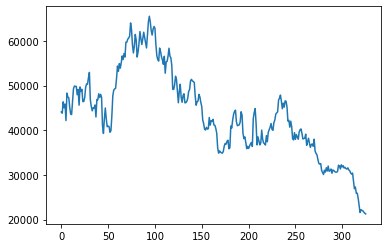

In [44]:
# Plots the predicted test values
plt.plot(y_predicted)
# Plots the true historic close values

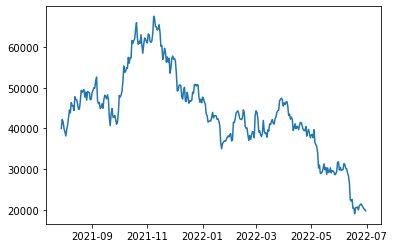

In [42]:
# Plots the true historic close values
plt.plot(df.iloc[760:]['close'])

In [39]:
y[-326]

array([43798.1171875])

760